## Imports

In [56]:
import warnings

import datetime as dt

import numpy as np 
import pandas as pd 

import os

import json

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import chi2_contingency

from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support, accuracy_score

## Config

In [57]:
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

## Global variables

In [58]:
LABELED_DATA_PATH = "/kaggle/input/184-702-tu-ml-2025w-breast-cancer/breast-cancer-diagnostic.shuf.lrn.csv"
UNLABELED_DATA_PATH = "/kaggle/input/184-702-tu-ml-2025w-breast-cancer/breast-cancer-diagnostic.shuf.tes.csv"

In [59]:
METRICS = {}

## Data Ingestion

In [60]:
df_raw_labeled = pd.read_csv(LABELED_DATA_PATH)
df_raw_test = pd.read_csv(UNLABELED_DATA_PATH)

In [61]:
df_raw_labeled.columns = [c.strip() for c in df_raw_labeled.columns]
df_raw_test.columns = [c.strip() for c in df_raw_test.columns]

In [62]:
display(df_raw_labeled.head())
display(df_raw_test.head())

ID  class  radiusMean  textureMean  perimeterMean  areaMean  \
0  8813129  False       13.27        17.02          84.55     546.4   
1   898678  False       12.06        18.90          76.66     445.3   
2   917896  False       13.71        18.68          88.73     571.0   
3   869691   True       11.80        16.58          78.99     432.0   
4  9110127   True       18.03        16.85         117.50     990.0   

   smoothnessMean  compactnessMean  concavityMean  concavePointsMean  ...  \
0         0.08445          0.04994        0.03554           0.024560  ...   
1         0.08386          0.05794        0.00751           0.008488  ...   
2         0.09916          0.10700        0.05385           0.037830  ...   
3         0.10910          0.17000        0.16590           0.074150  ...   
4         0.08947          0.12320        0.10900           0.062540  ...   

   radiusWorst  textureWorst  perimeterWorst  areaWorst  smoothnessWorst  \
0        15.14         23.60           98.84      708.8           0.1276   
1        13.64         27.06           86.54      562.6           0.1289   
2        15.11         25.63           99.43      701.9           0.1425   
3        13.74         26.38           91.93      591.7           0.1385   
4        20.38         22.02          133.30     1292.0           0.1263   

   compactnessWorst  concavityWorst  concavePointsWorst  symmetryWorst  \
0            0.1311         0.17860             0.09678         0.2506   
1            0.1352         0.04506             0.05093         0.2880   
2            0.2566         0.19350             0.12840         0.2849   
3            0.4092         0.45040             0.18650         0.5774   
4            0.2666         0.42900             0.15350         0.2842   

   fractalDimensionWorst  
0                0.07623  
1                0.08083  
2                0.09031  
3                0.10300  
4                0.08225  

[5 rows x 32 columns]

ID  radiusMean  textureMean  perimeterMean  areaMean  smoothnessMean  \
0    884437      10.480        19.86          66.72     337.7         0.10700   
1    901011      11.140        14.07          71.24     384.6         0.07274   
2    865432      14.500        10.89          94.28     640.7         0.11010   
3    894329       9.042        18.90          60.07     244.5         0.09968   
4  84348301      11.420        20.38          77.58     386.1         0.14250   

   compactnessMean  concavityMean  concavePointsMean  symmetryMean  ...  \
0          0.05971        0.04831            0.03070        0.1737  ...   
1          0.06064        0.04505            0.01471        0.1690  ...   
2          0.10990        0.08842            0.05778        0.1856  ...   
3          0.19720        0.19750            0.04908        0.2330  ...   
4          0.28390        0.24140            0.10520        0.2597  ...   

   radiusWorst  textureWorst  perimeterWorst  areaWorst  smoothnessWorst  \
0        11.48         29.46           73.68      402.8          0.15150   
1        12.12         15.82           79.62      453.5          0.08864   
2        15.70         15.98          102.80      745.5          0.13130   
3        10.06         23.40           68.62      297.1          0.12210   
4        14.91         26.50           98.87      567.7          0.20980   

   compactnessWorst  concavityWorst  concavePointsWorst  symmetryWorst  \
0            0.1026          0.1181             0.06736         0.2883   
1            0.1256          0.1201             0.03922         0.2576   
2            0.1788          0.2560             0.12210         0.2889   
3            0.3748          0.4609             0.11450         0.3135   
4            0.8663          0.6869             0.25750         0.6638   

   fractalDimensionWorst  
0                0.07748  
1                0.07018  
2                0.08006  
3                0.10550  
4                0.17300  

[5 rows x 31 columns]

# First Iteration

## Initial Analysis

### Nulls

There are no nulls in the dataset

In [63]:
null_summary = pd.concat(
    [
        pd.DataFrame(df_raw_labeled.isna().sum(), columns=["Train/Val"]), 
        pd.DataFrame(df_raw_test.isna().sum(), columns=["Test"])
    ], axis=1)
null_summary

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


Train/Val  Test
ID                              0   0.0
class                           0   NaN
radiusMean                      0   0.0
textureMean                     0   0.0
perimeterMean                   0   0.0
areaMean                        0   0.0
smoothnessMean                  0   0.0
compactnessMean                 0   0.0
concavityMean                   0   0.0
concavePointsMean               0   0.0
symmetryMean                    0   0.0
fractalDimensionMean            0   0.0
radiusStdErr                    0   0.0
textureStdErr                   0   0.0
perimeterStdErr                 0   0.0
areaStdErr                      0   0.0
smoothnessStdErr                0   0.0
compactnessStdErr               0   0.0
concavityStdErr                 0   0.0
concavePointsStdErr             0   0.0
symmetryStdErr                  0   0.0
fractalDimensionStdErr          0   0.0
radiusWorst                     0   0.0
textureWorst                    0   0.0
perimeterWorst                  0   0.0
areaWorst                       0   0.0
smoothnessWorst                 0   0.0
compactnessWorst                0   0.0
concavityWorst                  0   0.0
concavePointsWorst              0   0.0
symmetryWorst                   0   0.0
fractalDimensionWorst           0   0.0

### Outliers

There are some amount of outliers in the data, but it seems that they are very informative as when many of the features has an outlier data, it is highly correlated with the True class, so we might choose not to handle them in any way. This does not mean necesarily that the outliers in the test dataset may also behave similar, but there is a good chance of that behavior also being present there. Another option would be to exclude them the training, and instead pass the outlier rows through a rules sytem and have the trained models focus on the non outlier rows.

In [64]:
def tag_iqr_outliers(df: pd.DataFrame, col: str) -> pd.DataFrame:
    df_outliers = df[["class", col]].copy()
    
    qs = df_outliers[col].quantile([0.25, 0.75])
    
    iqr = qs[0.75] - qs[0.25]
    
    iqr_lower = qs[0.25] - (1.5*iqr)
    iqr_upper = qs[0.75] + (1.5*iqr)
    
    df_outliers["outlier_cat"] = np.where((df_outliers[col] < iqr_lower) | (df_outliers[col] > iqr_upper), "outlier", "inlier")
    df_outliers = df_outliers[df_outliers["outlier_cat"] == "outlier"]
    
    return df_outliers


def get_numeric_feature_columns(df: pd.DataFrame) -> list:
    num_cols = df.drop(["ID", "class"], axis=1, errors="ignore").select_dtypes(include=np.number).columns
    
    return num_cols


def make_plot_grid_ax(num_cols: list, plot_cols: int = 3, subfigsize: tuple = (20, 5)) -> plt.axis:
    plot_cols = plot_cols
    plot_rows = int(np.ceil((len(num_cols)/plot_cols)))
    
    fig, ax = plt.subplots(plot_rows, plot_cols, figsize=(subfigsize[0], subfigsize[1] * plot_rows))
    ax = ax.flatten()
    
    return ax

def plot_box_grid(df: pd.DataFrame, subfigsize: tuple = (20, 5)) -> None:
    num_cols = get_numeric_feature_columns(df=df)

    ax = make_plot_grid_ax(num_cols=num_cols, plot_cols=3, subfigsize=subfigsize)
    
    for i, col in enumerate(num_cols):
        sns.boxplot(data=df, y=col, ax=ax[i])

    plt.tight_layout()

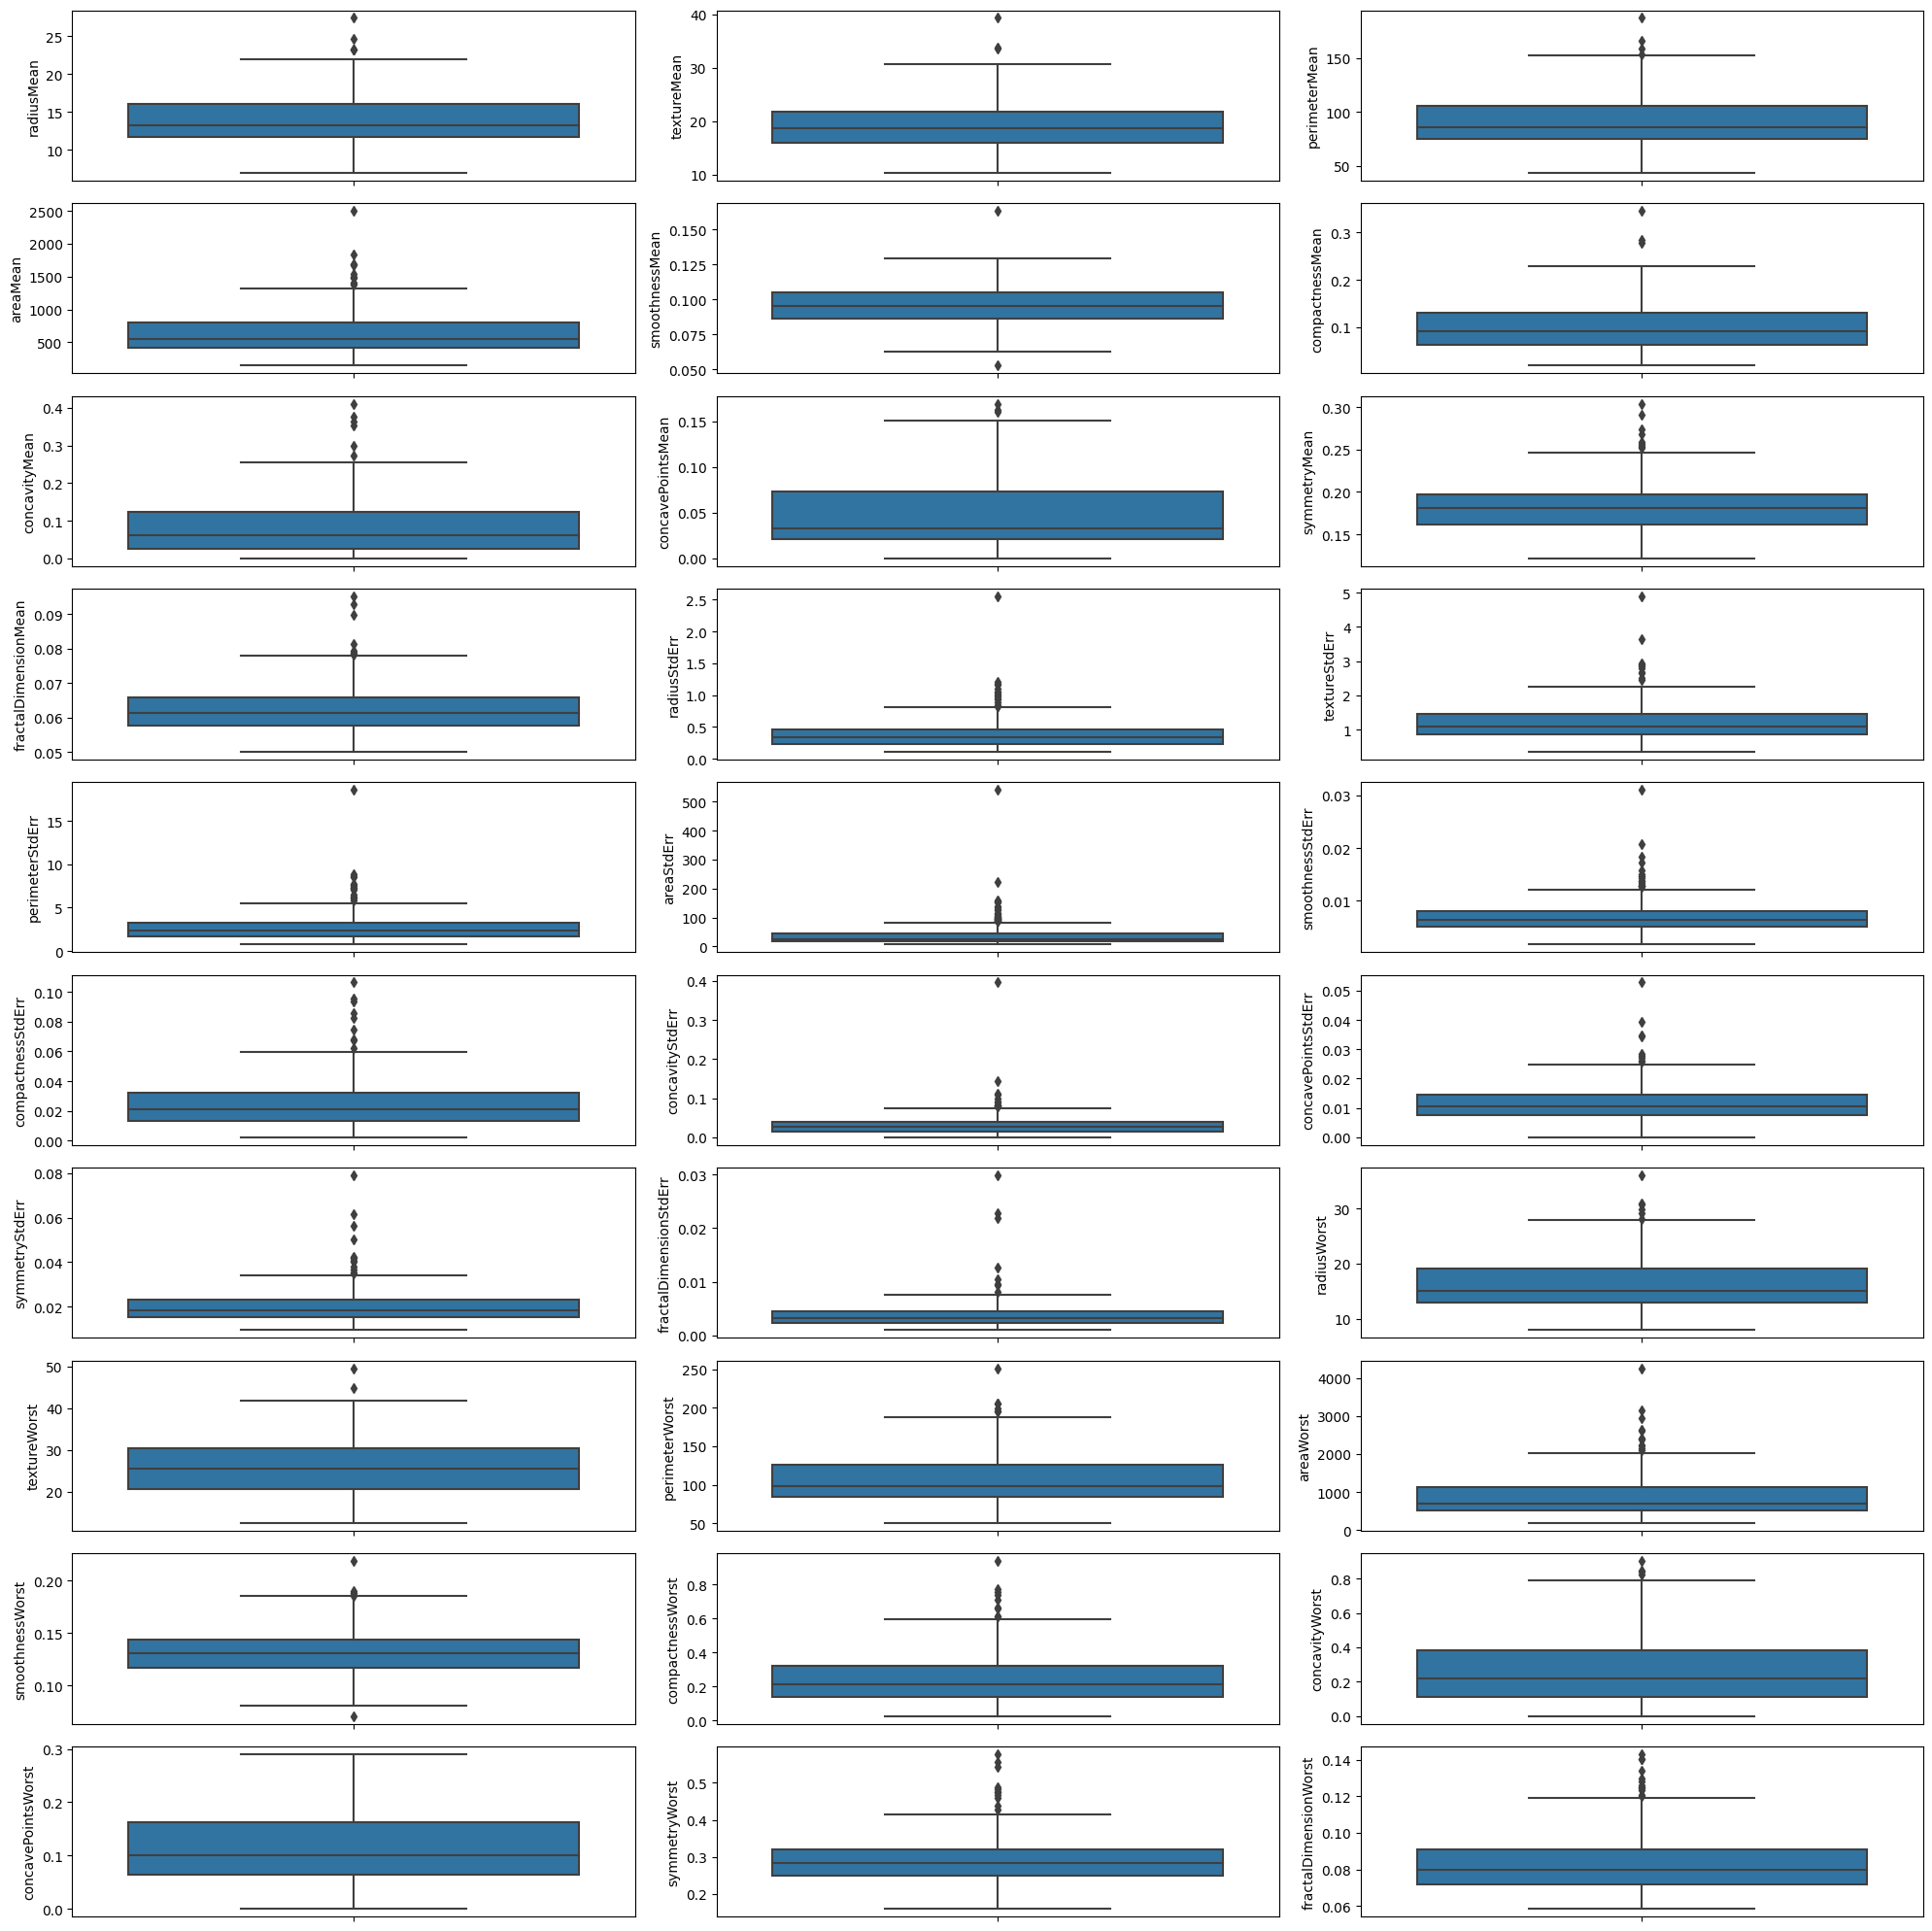

In [65]:
plot_box_grid(df=df_raw_labeled, subfigsize=(20,2))

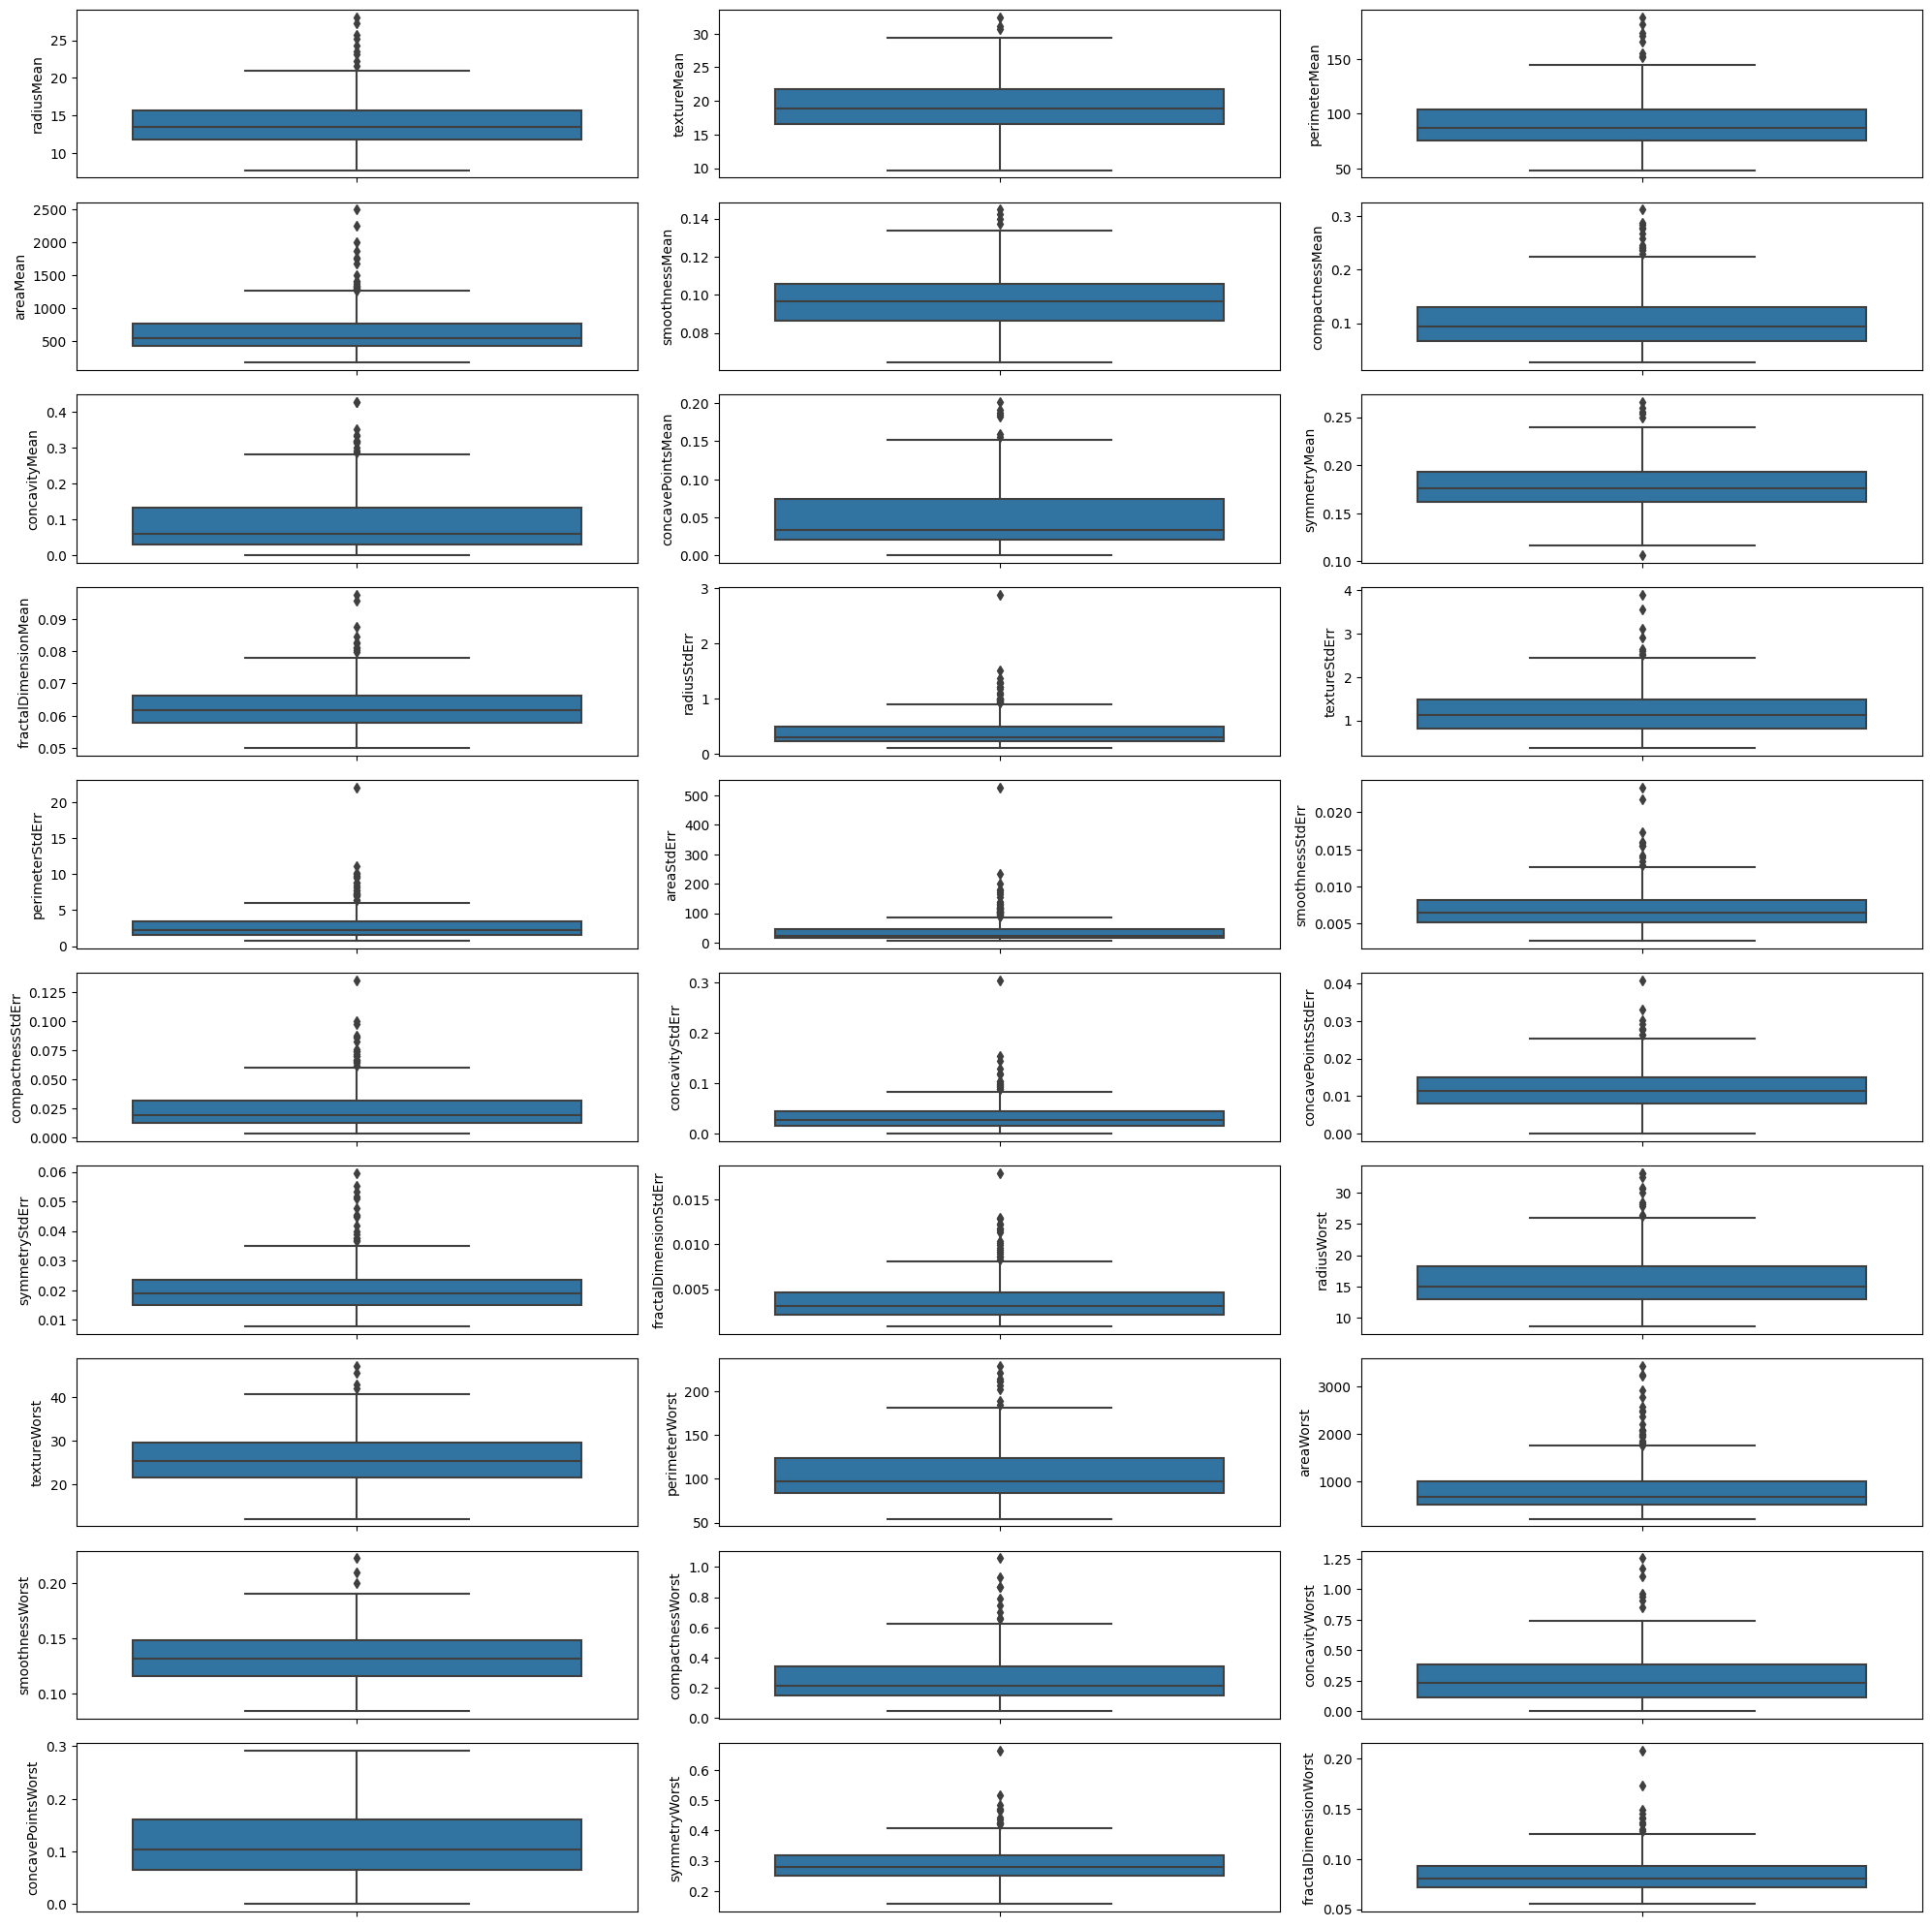

In [66]:
plot_box_grid(df=df_raw_test, subfigsize=(20,2))

In [67]:
num_cols = get_numeric_feature_columns(df=df_raw_labeled)

ax = make_plot_grid_ax(num_cols=num_cols, plot_cols=3, subfigsize=(20, 2))
custom_palette = {True: "orange", False: "blue"}

for i, col in enumerate(num_cols):
    df_outliers = tag_iqr_outliers(df=df_raw_labeled, col=col)

    ax[i].set_ylabel(col)
    ax[i].set_xlabel("class")
    
    if df_outliers.shape[0] == 0:
        print(f"{col} does not have any IQR outliers.")
        continue

    df_outliers_grouped = df_outliers.groupby("class")[col].count().reset_index()
    sns.barplot(data=df_outliers_grouped, x="class", y=col, hue="class", ax=ax[i], palette=custom_palette)

plt.tight_layout()

concavePointsWorst does not have any IQR outliers.


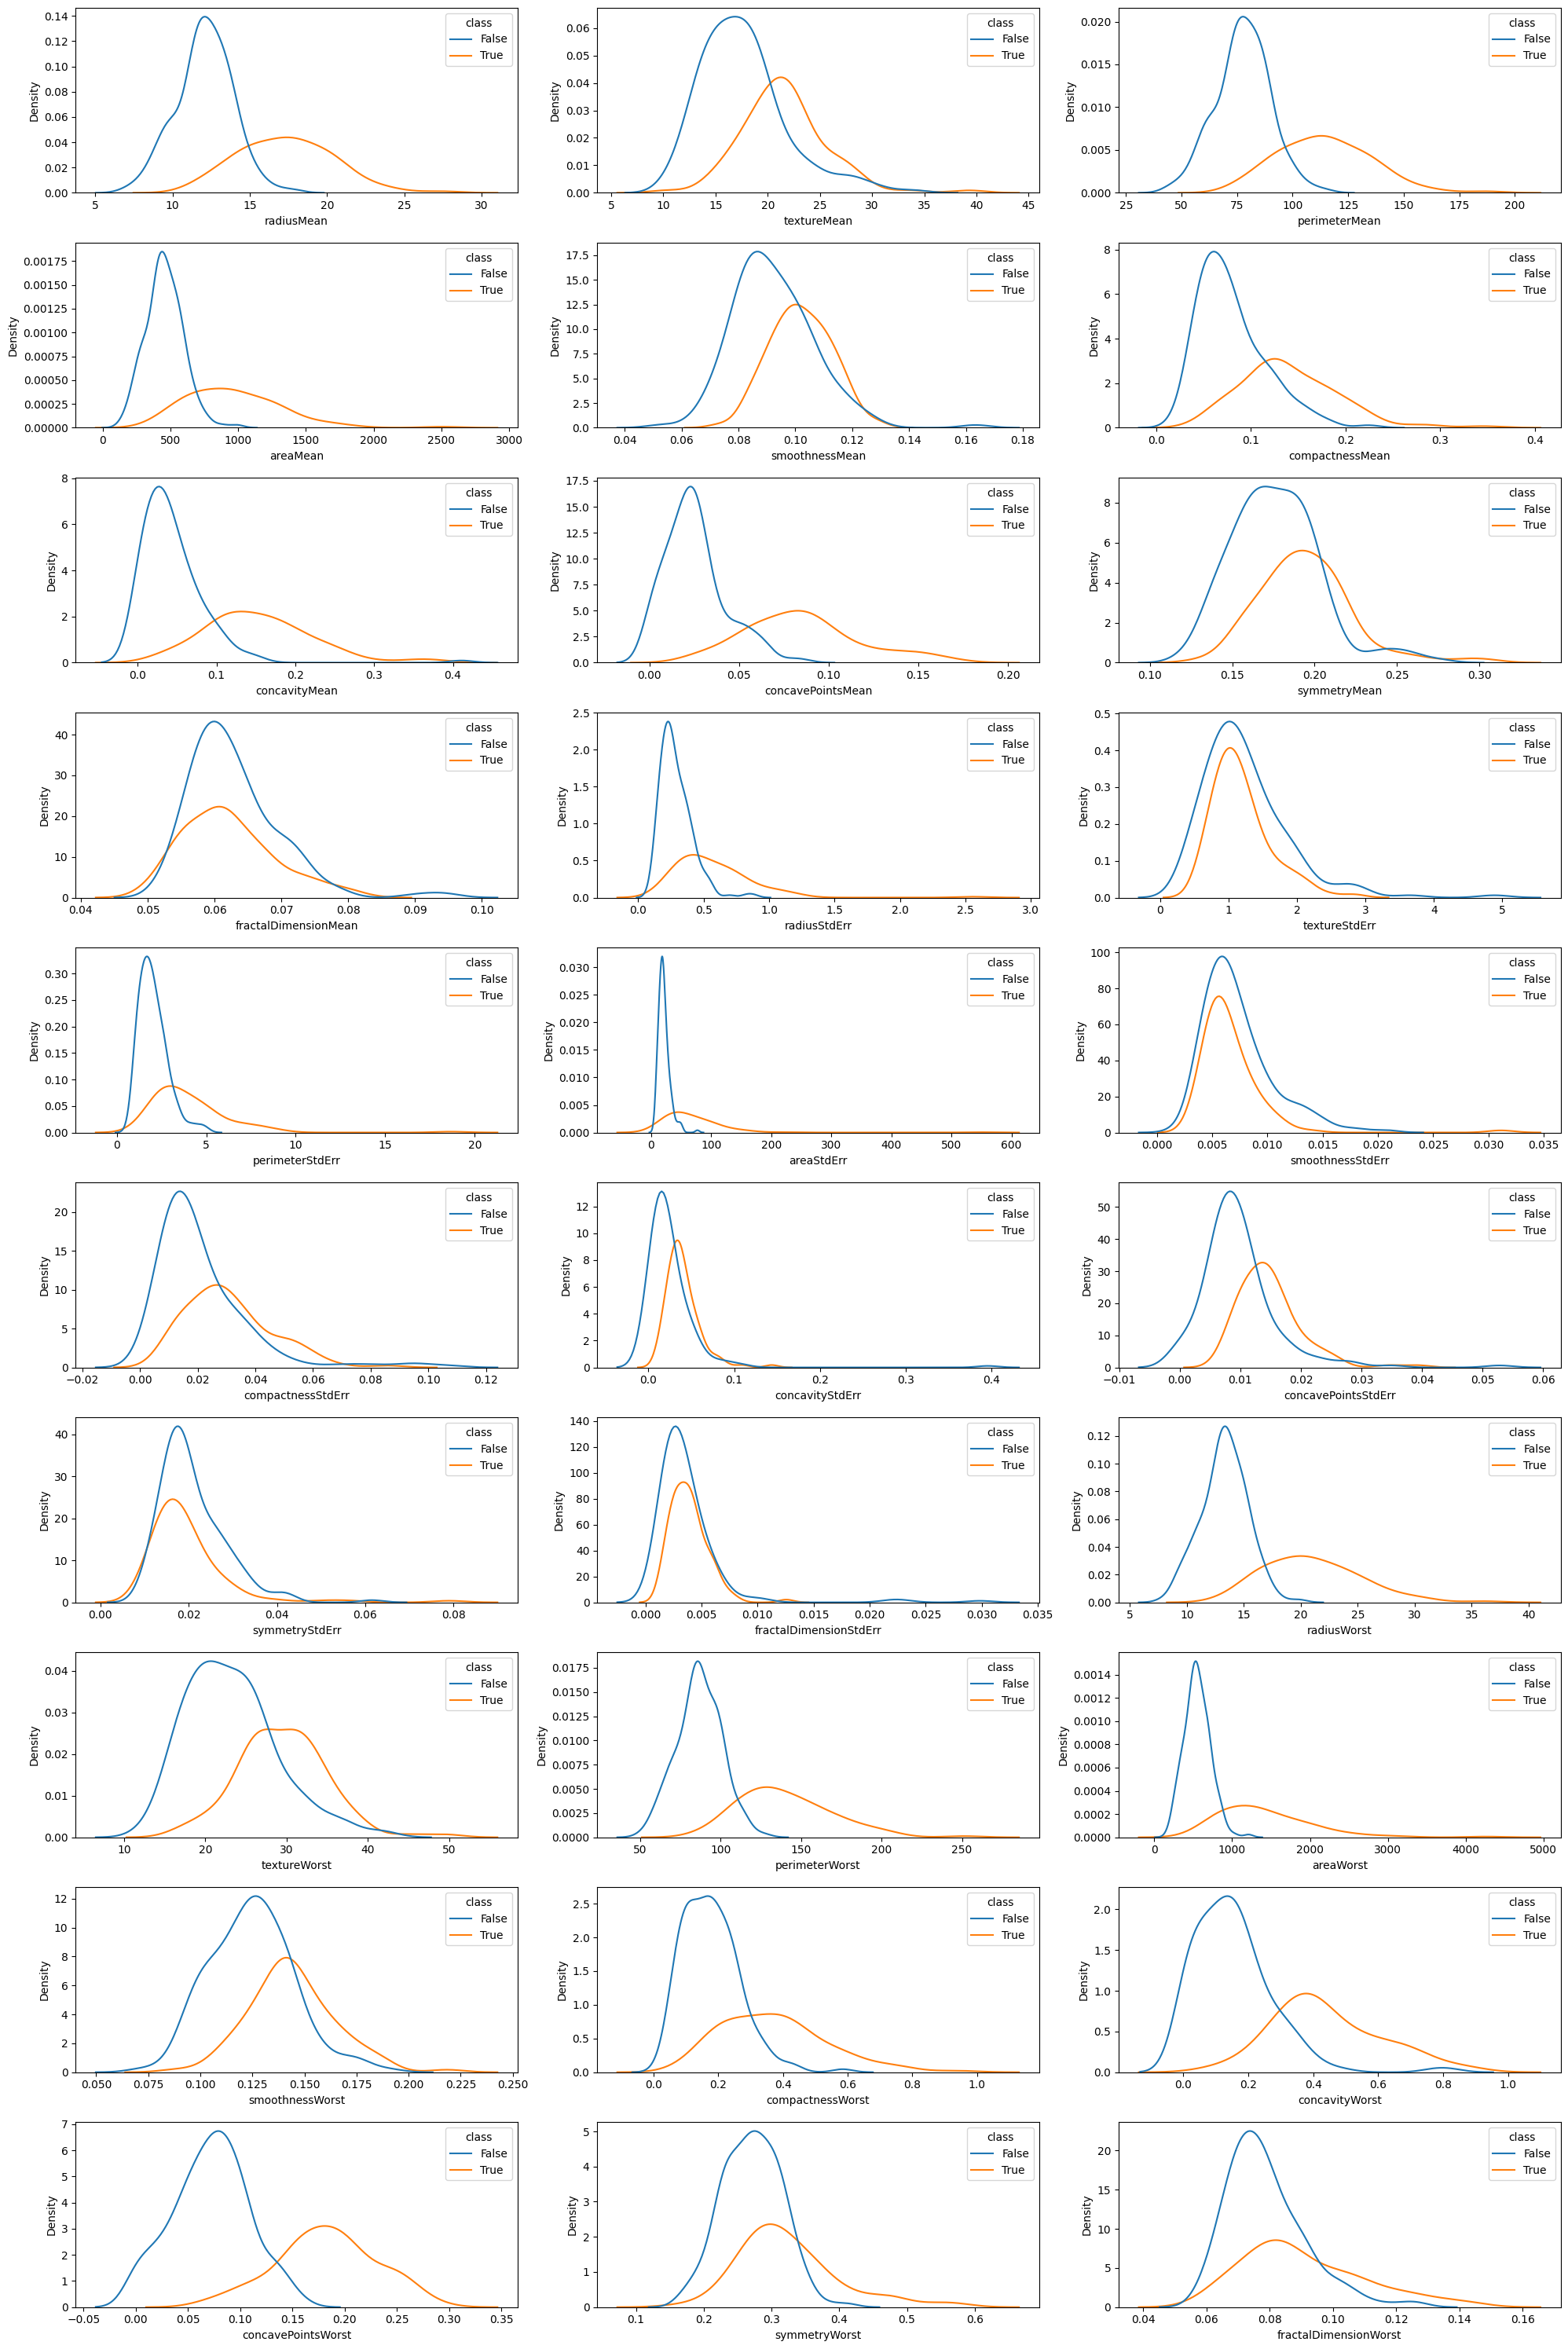

In [68]:
num_cols = df_raw_labeled.select_dtypes(include=np.number).drop(["class", "ID"], axis=1, errors="ignore").columns

plot_cols = 3
plot_rows = int(np.ceil((len(num_cols)/plot_cols)))

fig, ax = plt.subplots(plot_rows, plot_cols, figsize=(20, 3 * plot_rows))
ax = ax.flatten()

for i, col in enumerate(num_cols):
    sns.kdeplot(data=df_raw_labeled, x=col, hue="class", ax=ax[i])

plt.tight_layout()

In [69]:
df_raw_labeled

ID  class  radiusMean  textureMean  perimeterMean  areaMean  \
0     8813129  False       13.27        17.02          84.55     546.4   
1      898678  False       12.06        18.90          76.66     445.3   
2      917896  False       13.71        18.68          88.73     571.0   
3      869691   True       11.80        16.58          78.99     432.0   
4     9110127   True       18.03        16.85         117.50     990.0   
..        ...    ...         ...          ...            ...       ...   
280  89864002  False       11.71        15.45          75.03     420.3   
281    884626  False       12.89        14.11          84.95     512.2   
282    892189   True       11.76        18.14          75.00     431.1   
283    919812  False       11.69        24.44          76.37     406.4   
284   8810158  False       13.11        22.54          87.02     529.4   

     smoothnessMean  compactnessMean  concavityMean  concavePointsMean  ...  \
0           0.08445          0.04994        0.03554           0.024560  ...   
1           0.08386          0.05794        0.00751           0.008488  ...   
2           0.09916          0.10700        0.05385           0.037830  ...   
3           0.10910          0.17000        0.16590           0.074150  ...   
4           0.08947          0.12320        0.10900           0.062540  ...   
..              ...              ...            ...                ...  ...   
280         0.11500          0.07281        0.04006           0.032500  ...   
281         0.08760          0.13460        0.13740           0.039800  ...   
282         0.09968          0.05914        0.02685           0.035150  ...   
283         0.12360          0.15520        0.04515           0.045310  ...   
284         0.10020          0.14830        0.08705           0.051020  ...   

     radiusWorst  textureWorst  perimeterWorst  areaWorst  smoothnessWorst  \
0          15.14         23.60           98.84      708.8           0.1276   
1          13.64         27.06           86.54      562.6           0.1289   
2          15.11         25.63           99.43      701.9           0.1425   
3          13.74         26.38           91.93      591.7           0.1385   
4          20.38         22.02          133.30     1292.0           0.1263   
..           ...           ...             ...        ...              ...   
280        13.06         18.16           84.16      516.4           0.1460   
281        14.39         17.70          105.00      639.1           0.1254   
282        13.36         23.39           85.10      553.6           0.1137   
283        12.98         32.19           86.12      487.7           0.1768   
284        14.55         29.16           99.48      639.3           0.1349   

     compactnessWorst  concavityWorst  concavePointsWorst  symmetryWorst  \
0             0.13110         0.17860             0.09678         0.2506   
1             0.13520         0.04506             0.05093         0.2880   
2             0.25660         0.19350             0.12840         0.2849   
3             0.40920         0.45040             0.18650         0.5774   
4             0.26660         0.42900             0.15350         0.2842   
..                ...             ...                 ...            ...   
280           0.11150         0.10870             0.07864         0.2765   
281           0.58490         0.77270             0.15610         0.2639   
282           0.07974         0.06120             0.07160         0.1978   
283           0.32510         0.13950             0.13080         0.2803   
284           0.44020         0.31620             0.11260         0.4128   

     fractalDimensionWorst  
0                  0.07623  
1                  0.08083  
2                  0.09031  
3                  0.10300  
4                  0.08225  
..                     ...  
280                0.07806  
281                0.11780  
282                0.06915  
283                0.09970  
284 

In [70]:
df_corr = df_raw_labeled.copy()
df_corr["class"] = df_corr["class"].astype(int)
df_corr = df_corr.select_dtypes(include=np.number).drop(["ID"], axis=1, errors="ignore").corr()
display(df_corr)

plt.figure(figsize=(15,15))
sns.heatmap(df_corr, annot=True, center=0.0)

class  radiusMean  textureMean  perimeterMean  \
class                   1.000000    0.733513     0.422638       0.743500   
radiusMean              0.733513    1.000000     0.336754       0.997917   
textureMean             0.422638    0.336754     1.000000       0.338787   
perimeterMean           0.743500    0.997917     0.338787       1.000000   
areaMean                0.714253    0.986544     0.340337       0.985754   
smoothnessMean          0.338718    0.157545    -0.036714       0.193513   
compactnessMean         0.575159    0.526495     0.184018       0.575284   
concavityMean           0.703754    0.692159     0.283089       0.728648   
concavePointsMean       0.777360    0.831005     0.283337       0.857191   
symmetryMean            0.310818    0.147605     0.030440       0.181300   
fractalDimensionMean   -0.056974   -0.321051    -0.138916      -0.274267   
radiusStdErr            0.543158    0.675204     0.251823       0.686318   
textureStdErr          -0.046400   -0.150740     0.317340      -0.149993   
perimeterStdErr         0.544378    0.679033     0.249935       0.696943   
areaStdErr              0.524975    0.723635     0.246249       0.732031   
smoothnessStdErr       -0.103788   -0.254049    -0.010582      -0.237758   
compactnessStdErr       0.280756    0.239665     0.131294       0.281694   
concavityStdErr         0.242228    0.211983     0.096655       0.241138   
concavePointsStdErr     0.384836    0.395065     0.103511       0.422745   
symmetryStdErr         -0.072888   -0.183874    -0.044725      -0.161744   
fractalDimensionStdErr  0.040789   -0.043013    -0.010401      -0.012402   
radiusWorst             0.773925    0.974413     0.353912       0.974166   
textureWorst            0.480592    0.322692     0.914263       0.322993   
perimeterWorst          0.778868    0.969640     0.351458       0.974502   
areaWorst               0.728420    0.942497     0.341271       0.943047   
smoothnessWorst         0.423513    0.124178     0.066600       0.153852   
compactnessWorst        0.610757    0.465992     0.237557       0.506355   
concavityWorst          0.700155    0.589395     0.275313       0.623724   
concavePointsWorst      0.797757    0.764128     0.283469       0.788742   
symmetryWorst           0.410771    0.180391     0.075230       0.206029   
fractalDimensionWorst   0.353929    0.068976     0.090605       0.110896   

                        areaMean  smoothnessMean  compactnessMean  \
class                   0.714253        0.338718         0.575159   
radiusMean              0.986544        0.157545         0.526495   
textureMean             0.340337       -0.036714         0.184018   
perimeterMean           0.985754        0.193513         0.575284   
areaMean                1.000000        0.155572         0.513626   
smoothnessMean          0.155572        1.000000         0.665439   
compactnessMean         0.513626        0.665439         1.000000   
concavityMean           0.696621        0.501771         0.858225   
concavePointsMean       0.827718        0.524537         0.825393   
symmetryMean            0.153239        0.529569         0.579121   
fractalDimensionMean   -0.294615        0.617052         0.520096   
radiusStdErr            0.738805        0.260273         0.485560   
textureStdErr          -0.121079        0.005707        -0.113864   
perimeterStdErr         0.741196        0.273210         0.545174   
areaStdErr              0.797566        0.202166         0.445069   
smoothnessStdErr       -0.209672        0.273752         0.049757   
compactnessStdErr       0.240212        0.327968         0.708939   
concavityStdErr         0.219418        0.234646         0.502065   
concavePointsStdErr     0.391473        0.410449         0.620884   
symmetryStdErr         -0.156833        0.127102         0.142547   
fractalDimensionStdErr -0.022419        0.295648         0.427155   
radiusWorst             0.971577        0.196356         0.548862   
texture

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


<Axes: >

## Modeling

In [71]:
def train_test_split_print(df: pd.DataFrame, train_pct: float = 0.7, seed: int = 42) -> tuple:
    df_train, df_test = train_test_split(df, train_size=train_pct, random_state=seed, shuffle=True)

    print(f"Train rows: {df_train.shape[0]}")
    print(f"Test rows: {df_test.shape[0]}")

    return df_train, df_test


def get_X_y(df: pd.DataFrame, lbl_col: str) -> tuple:
    X = df[[c for c in df.columns if c != lbl_col]].drop("ID", axis=1)
    y = df[lbl_col]

    return X, y


def print_prfs(prfs: list, label: str) -> None:
    display(pd.DataFrame({
        f"{label} Precision": [prfs[0]], 
        f"{label} Recall": [prfs[1]], 
        f"{label} F1": [prfs[2]], 
    }))

def display_train_test_confusion_matrix(y_train: np.array, y_test: np.array, train_y_pred: np.array, test_y_pred: np.array) -> None:
    cm_train = confusion_matrix(y_train, train_y_pred)
    cm_test = confusion_matrix(y_test, test_y_pred)
    
    fig, ax = plt.subplots(1,2, figsize=(12, 6))
    
    cm_train_display = ConfusionMatrixDisplay(cm_train)
    cm_train_display.plot(ax=ax[0])
    
    cm_test_display = ConfusionMatrixDisplay(cm_test)
    cm_test_display.plot(ax=ax[1])
    
    ax[0].title.set_text("Train Confusion Matrix")
    ax[1].title.set_text("Test Confusion Matrix")
    
    plt.tight_layout()

def prepare_cv_datasets(df: pd.DataFrame, cv_seeds: list = [1, 7, 42, 100, 120], lbl_col: str = "class"):
    train_cv_dfs = []
    test_cv_dfs = []

    for seed in cv_seeds:
        # Split dataset into train and test
        df_train, df_test = train_test_split_print(df=df, train_pct=0.7, seed=seed)

        # Separate the features from the label
        X_train, y_train = get_X_y(df=df_train, lbl_col=lbl_col)
        X_test, y_test = get_X_y(df=df_test, lbl_col=lbl_col)

        # Uncomment only if DF has categorical, which in this case it doesn't
        #cat_cols = []
        #X_train_num = X_train[[c for c in X_train.columns if c not in cat_cols]]
        #X_test_num = X_test[[c for c in X_test.columns if c not in cat_cols]]

        ## Encode the categoricals, by fitting on the training split and then applying over the testing split
        #one_hot_enc = OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop="first")
        #X_train_enc = one_hot_enc.fit_transform(X_train[cat_cols]) 
        #X_test_enc = one_hot_enc.transform(X_test[cat_cols])

        # We rejoin the numeric and categorical encoded columns
        #X_train = np.hstack((X_train_num, X_train_enc))
        #X_test = np.hstack((X_test_num, X_test_enc))

        # Scale data to make it more efficient
        scaler = StandardScaler()
        scaler.fit(X_train)
        
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)

        # Generate 
        train_cv_dfs.append((X_train, y_train))
        test_cv_dfs.append((X_test, y_test))
        
    return train_cv_dfs, test_cv_dfs

In [72]:
cv_seeds=[0, 1, 7, 42, 100, 120, 123, 666, 999, 100000]
train_cv_dfs, test_cv_dfs = prepare_cv_datasets(df=df_raw_labeled, cv_seeds=cv_seeds, lbl_col="class")

Train rows: 199
Test rows: 86
Train rows: 199
Test rows: 86
Train rows: 199
Test rows: 86
Train rows: 199
Test rows: 86
Train rows: 199
Test rows: 86
Train rows: 199
Test rows: 86
Train rows: 199
Test rows: 86
Train rows: 199
Test rows: 86
Train rows: 199
Test rows: 86
Train rows: 199
Test rows: 86


### LogisticRegression

In [73]:
step = "Baseline"

In [74]:
METRICS["LogisticRegression"] = {}

Training Precision  Training Recall  Training F1
0            0.992809         0.988081     0.990336

Test Precision  Test Recall   Test F1
0         0.95901     0.959282  0.958706

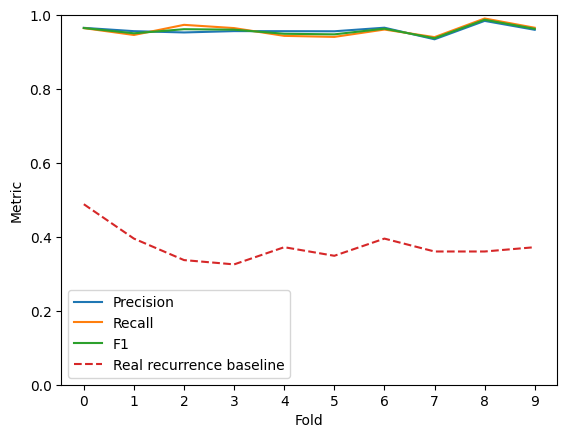

In [75]:
train_prfs_arr = np.empty((len(cv_seeds), 4))
test_prfs_arr = np.empty((len(cv_seeds), 4))

proportion_lbls_test = np.empty((len(cv_seeds)))

for idx, fold in enumerate(zip(train_cv_dfs, test_cv_dfs)):
    X_train, y_train = fold[0]
    X_test, y_test = fold[1]

    proportion_lbls_test[idx] = y_test.sum() / y_test.count() 
    
    logistic_reg = LogisticRegression(random_state=42)
    logistic_reg.fit(X_train, y_train)
    
    train_y_pred = logistic_reg.predict(X_train)
    test_y_pred = logistic_reg.predict(X_test)
    
    #display_train_test_confusion_matrix(y_train=y_train, y_test=y_test, train_y_pred=train_y_pred, test_y_pred=test_y_pred)
    
    train_prfs = precision_recall_fscore_support(y_train, train_y_pred, average='macro')
    test_prfs = precision_recall_fscore_support(y_test, test_y_pred, average='macro')

    train_prfs_arr[idx] = train_prfs
    test_prfs_arr[idx] = test_prfs

plt.plot(test_prfs_arr[:, 0], label="Precision")
plt.plot(test_prfs_arr[:, 1], label="Recall")
plt.plot(test_prfs_arr[:, 2], label="F1")
plt.xticks(range(test_prfs_arr.shape[0]))
plt.ylabel("Metric")
plt.xlabel("Fold")
plt.ylim(0.0, 1.0)
plt.plot(proportion_lbls_test, label="Real recurrence baseline", linestyle="--")
plt.legend()

train_cv_prfs = train_prfs_arr.mean(axis=0)
test_cv_prfs = test_prfs_arr.mean(axis=0)

print_prfs(prfs=train_cv_prfs, label="Training")
print_prfs(prfs=test_cv_prfs, label="Test")

plt.figure()
sns.boxplot(test_prfs_arr)
ticks = plt.xticks()[0]
plt.xticks(ticks=ticks, labels=["Precision", "Recall", "F1", "Support"])
#plt.ylim(0.0, 1.0)

METRICS["LogisticRegression"][step] = {}
METRICS["LogisticRegression"][step]["train"] = tuple(train_cv_prfs)
METRICS["LogisticRegression"][step]["test"] = tuple(test_cv_prfs)

### Xgboost

In [76]:
METRICS["XGBClassifier"] = {}

Training Precision  Training Recall  Training F1
0                 1.0              1.0          1.0

Test Precision  Test Recall   Test F1
0        0.935794     0.940533  0.935685

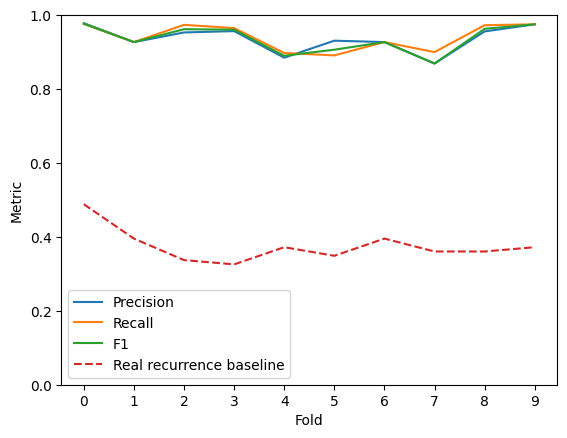

In [77]:
train_prfs_arr = np.empty((len(cv_seeds), 4))
test_prfs_arr = np.empty((len(cv_seeds), 4))

proportion_lbls_test = np.empty((len(cv_seeds)))

for idx, fold in enumerate(zip(train_cv_dfs, test_cv_dfs)):
    X_train, y_train = fold[0]
    X_test, y_test = fold[1]

    proportion_lbls_test[idx] = y_test.sum() / y_test.count() 
    
    xgbc_baseline = XGBClassifier(random_state=42)
    xgbc_baseline.fit(X_train, y_train)
    
    train_y_pred = xgbc_baseline.predict(X_train)
    test_y_pred = xgbc_baseline.predict(X_test)
    
    #display_train_test_confusion_matrix(y_train=y_train, y_test=y_test, train_y_pred=train_y_pred, test_y_pred=test_y_pred)
    
    train_prfs = precision_recall_fscore_support(y_train, train_y_pred, average='macro')
    test_prfs = precision_recall_fscore_support(y_test, test_y_pred, average='macro')

    train_prfs_arr[idx] = train_prfs
    test_prfs_arr[idx] = test_prfs

plt.plot(test_prfs_arr[:, 0], label="Precision")
plt.plot(test_prfs_arr[:, 1], label="Recall")
plt.plot(test_prfs_arr[:, 2], label="F1")
plt.xticks(range(test_prfs_arr.shape[0]))
plt.ylabel("Metric")
plt.xlabel("Fold")
plt.ylim(0.0, 1.0)
plt.plot(proportion_lbls_test, label="Real recurrence baseline", linestyle="--")
plt.legend()

train_cv_prfs = train_prfs_arr.mean(axis=0)
test_cv_prfs = test_prfs_arr.mean(axis=0)

print_prfs(prfs=train_cv_prfs, label="Training")
print_prfs(prfs=test_cv_prfs, label="Test")

plt.figure()
sns.boxplot(test_prfs_arr)
ticks = plt.xticks()[0]
plt.xticks(ticks=ticks, labels=["Precision", "Recall", "F1", "Support"])
#plt.ylim(0.0, 1.0)

METRICS["XGBClassifier"][step] = {}
METRICS["XGBClassifier"][step]["train"] = tuple(train_cv_prfs)
METRICS["XGBClassifier"][step]["test"] = tuple(test_cv_prfs)

### SVM

In [79]:
METRICS["SVM"] = {}

Training Precision  Training Recall  Training F1
0            0.986398          0.98157     0.983855

Test Precision  Test Recall   Test F1
0        0.968281     0.959726  0.963319

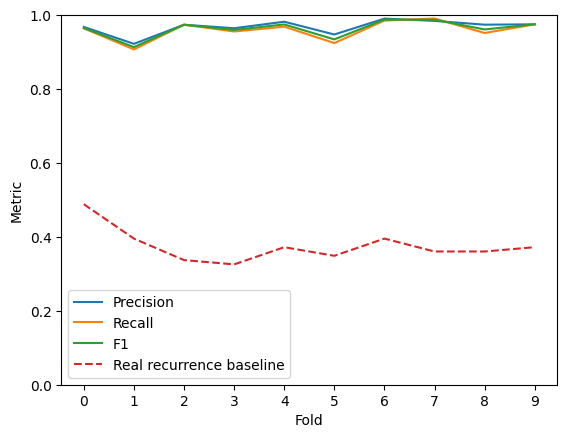

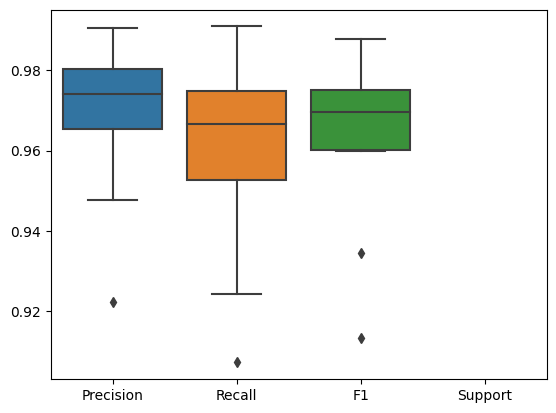

In [80]:
train_prfs_arr = np.empty((len(cv_seeds), 4))
test_prfs_arr = np.empty((len(cv_seeds), 4))

proportion_lbls_test = np.empty((len(cv_seeds)))

for idx, fold in enumerate(zip(train_cv_dfs, test_cv_dfs)):
    X_train, y_train = fold[0]
    X_test, y_test = fold[1]

    proportion_lbls_test[idx] = y_test.sum() / y_test.count() 
    
    clf = svm.SVC(random_state=42)
    clf.fit(X_train, y_train)
    
    train_y_pred = clf.predict(X_train)
    test_y_pred = clf.predict(X_test)
    
    #display_train_test_confusion_matrix(y_train=y_train, y_test=y_test, train_y_pred=train_y_pred, test_y_pred=test_y_pred)
    
    train_prfs = precision_recall_fscore_support(y_train, train_y_pred, average='macro')
    test_prfs = precision_recall_fscore_support(y_test, test_y_pred, average='macro')

    train_prfs_arr[idx] = train_prfs
    test_prfs_arr[idx] = test_prfs
plt.plot(test_prfs_arr[:, 0], label="Precision")
plt.plot(test_prfs_arr[:, 1], label="Recall")
plt.plot(test_prfs_arr[:, 2], label="F1")
plt.xticks(range(test_prfs_arr.shape[0]))
plt.ylabel("Metric")
plt.xlabel("Fold")
plt.ylim(0.0, 1.0)
plt.plot(proportion_lbls_test, label="Real recurrence baseline", linestyle="--")
plt.legend()

train_cv_prfs = train_prfs_arr.mean(axis=0)
test_cv_prfs = test_prfs_arr.mean(axis=0)

print_prfs(prfs=train_cv_prfs, label="Training")
print_prfs(prfs=test_cv_prfs, label="Test")

plt.figure()
sns.boxplot(test_prfs_arr)
ticks = plt.xticks()[0]
plt.xticks(ticks=ticks, labels=["Precision", "Recall", "F1", "Support"])
#plt.ylim(0.0, 1.0)

METRICS["SVM"][step] = {}
METRICS["SVM"][step]["train"] = tuple(train_cv_prfs)
METRICS["SVM"][step]["test"] = tuple(test_cv_prfs)

## Metrics so far

(0.9590103646062971, 0.9592824297104077, 0.9587062005225739, nan)
(0.9357942913750528, 0.9405332449223236, 0.935685310919876, nan)
(0.9682812259267172, 0.9597263863213333, 0.9633185681058386, nan)


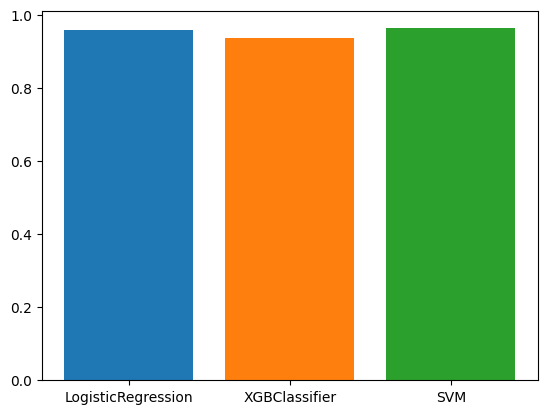

In [81]:
for k,v in METRICS.items():
    print(v[step]["test"])

    plt.bar(x=k, height=v[step]["test"][2])

In [82]:
print(json.dumps(METRICS, indent=4))

{
    "LogisticRegression": {
        "Baseline": {
            "train": [
                0.9928094003905628,
                0.9880805355747061,
                0.9903358587689869,
                NaN
            ],
            "test": [
                0.9590103646062971,
                0.9592824297104077,
                0.9587062005225739,
                NaN
            ]
        }
    },
    "XGBClassifier": {
        "Baseline": {
            "train": [
                1.0,
                1.0,
                1.0,
                NaN
            ],
            "test": [
                0.9357942913750528,
                0.9405332449223236,
                0.935685310919876,
                NaN
            ]
        }
    },
    "SVM": {
        "Baseline": {
            "train": [
                0.9863979719070229,
                0.9815695078816835,
                0.9838551969865614,
                NaN
            ],
            "test": [
                0.96828122592671

## Final Baseline Model

In [83]:
X_train, y_train = get_X_y(df_raw_labeled, lbl_col="class")
X_test = df_raw_test.drop("ID", axis=1)

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

logistic_reg = LogisticRegression(random_state=42)
logistic_reg.fit(X_train, y_train)

train_y_pred = logistic_reg.predict(X_train)
test_y_pred = logistic_reg.predict(X_test)

train_prfs = precision_recall_fscore_support(y_train, train_y_pred, average='macro')
train_prfs

(0.994413407821229, 0.9907407407407407, 0.9925181140396935, None)

In [84]:
submission_dt = dt.datetime.now().strftime("%Y%m%d_%H%M%S")

submission = pd.DataFrame({"ID": df_raw_test["ID"], "class": test_y_pred})
submission = submission.replace({False: "false", True: "true"})
submission 

save_path = "submissions/baseline"
sub = "."
for part in save_path.split("/"):
    sub = sub + "/" + part 
    try:
        os.mkdir(sub)
        print(f"Created path {sub}")
    except FileExistsError:
        print(f"Path {sub} already exists.")
        pass

submission.to_csv(f"{save_path}/submission_{submission_dt}.csv", index=False)

Path ./submissions already exists.
Path ./submissions/baseline already exists.


In [85]:
submission.groupby("class").count()

ID
class     
false  183
true   101

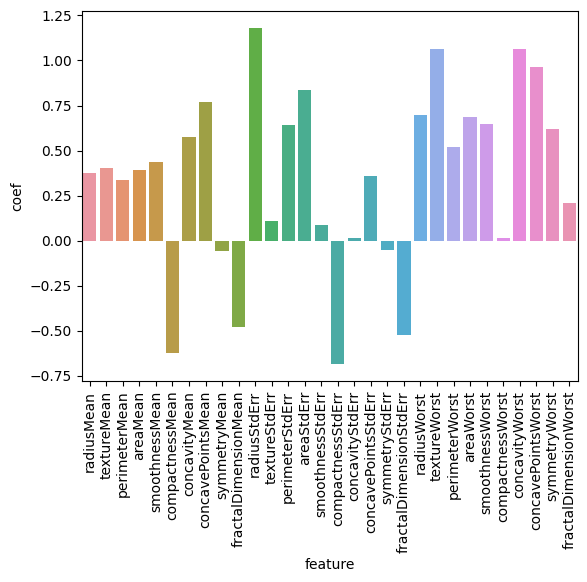

In [86]:
df_logreg_importance = pd.DataFrame({"feature": df_raw_test.drop("ID", axis=1).columns, "coef": logistic_reg.coef_[0]})

sns.barplot(data=df_logreg_importance, x="feature", y="coef")
plt.xticks(rotation=90);

# Second Iteration

## Feature Engineering

In [87]:
df_raw_labeled.columns

Index(['ID', 'class', 'radiusMean', 'textureMean', 'perimeterMean', 'areaMean',
       'smoothnessMean', 'compactnessMean', 'concavityMean',
       'concavePointsMean', 'symmetryMean', 'fractalDimensionMean',
       'radiusStdErr', 'textureStdErr', 'perimeterStdErr', 'areaStdErr',
       'smoothnessStdErr', 'compactnessStdErr', 'concavityStdErr',
       'concavePointsStdErr', 'symmetryStdErr', 'fractalDimensionStdErr',
       'radiusWorst', 'textureWorst', 'perimeterWorst', 'areaWorst',
       'smoothnessWorst', 'compactnessWorst', 'concavityWorst',
       'concavePointsWorst', 'symmetryWorst', 'fractalDimensionWorst'],
      dtype='object')

In [88]:
new_cols_train = []
new_cols_test = []

cols_created = []

# Extract columns first because otherwise we will be iterating over newly created columns
start_cols1 = list(sorted(df_raw_labeled.columns[2:]))
start_cols2 = start_cols1[1:]

for col1 in start_cols1:
    for col2 in start_cols2:
        if col1 == col2:
            continue

        if f"{col2}_by_{col1}" in cols_created:
            continue
        
        out_col = f"{col1}_by_{col2}"

        print(f"Creating {out_col}")
        cols_created.append(out_col)

        new_cols_train.append((col1, col2, out_col, df_raw_labeled[col1] * (df_raw_labeled[col2])))
        new_cols_test.append((col1, col2, out_col, df_raw_test[col1] * (df_raw_test[col2])))

Creating areaMean_by_areaStdErr
Creating areaMean_by_areaWorst
Creating areaMean_by_compactnessMean
Creating areaMean_by_compactnessStdErr
Creating areaMean_by_compactnessWorst
Creating areaMean_by_concavePointsMean
Creating areaMean_by_concavePointsStdErr
Creating areaMean_by_concavePointsWorst
Creating areaMean_by_concavityMean
Creating areaMean_by_concavityStdErr
Creating areaMean_by_concavityWorst
Creating areaMean_by_fractalDimensionMean
Creating areaMean_by_fractalDimensionStdErr
Creating areaMean_by_fractalDimensionWorst
Creating areaMean_by_perimeterMean
Creating areaMean_by_perimeterStdErr
Creating areaMean_by_perimeterWorst
Creating areaMean_by_radiusMean
Creating areaMean_by_radiusStdErr
Creating areaMean_by_radiusWorst
Creating areaMean_by_smoothnessMean
Creating areaMean_by_smoothnessStdErr
Creating areaMean_by_smoothnessWorst
Creating areaMean_by_symmetryMean
Creating areaMean_by_symmetryStdErr
Creating areaMean_by_symmetryWorst
Creating areaMean_by_textureMean
Creating a

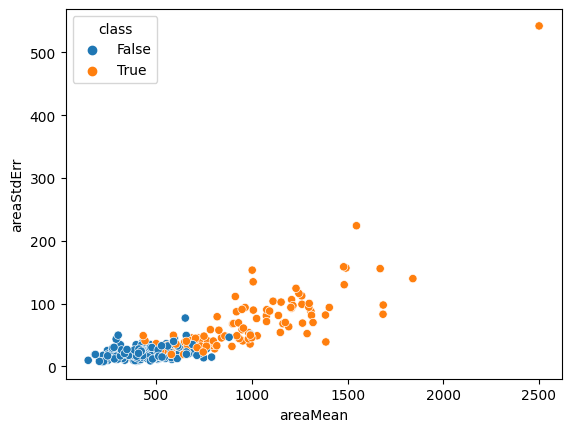

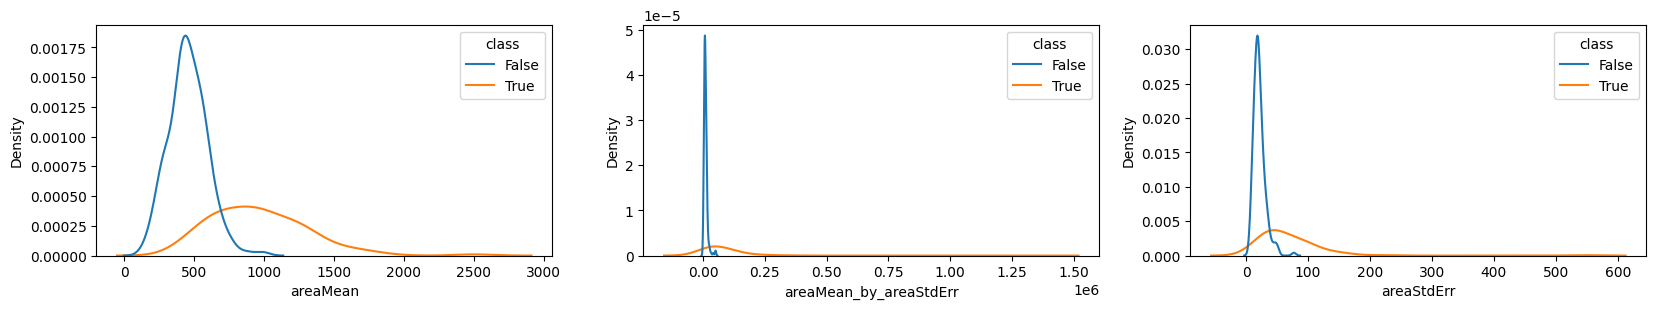

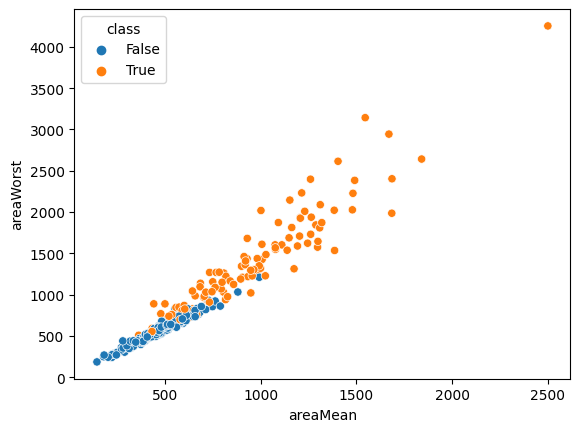

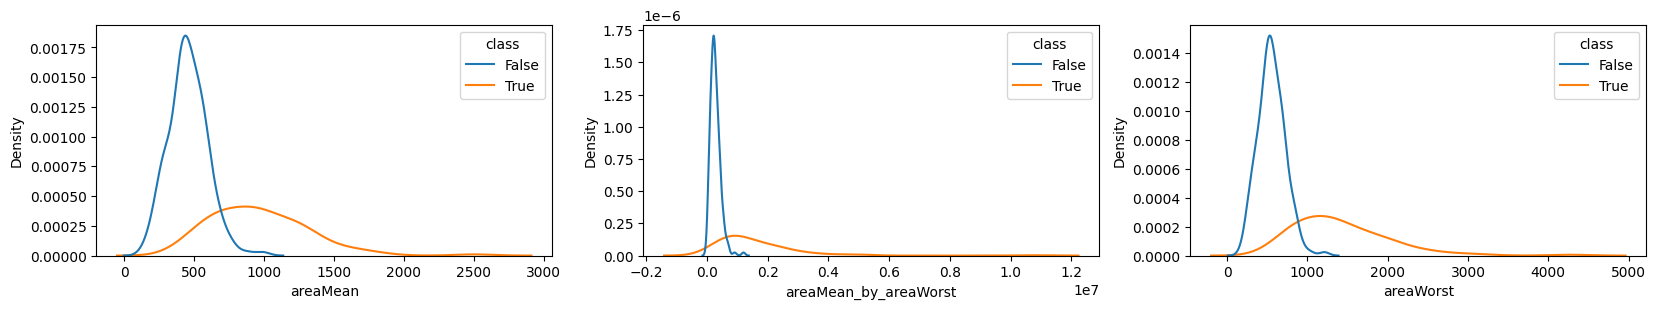

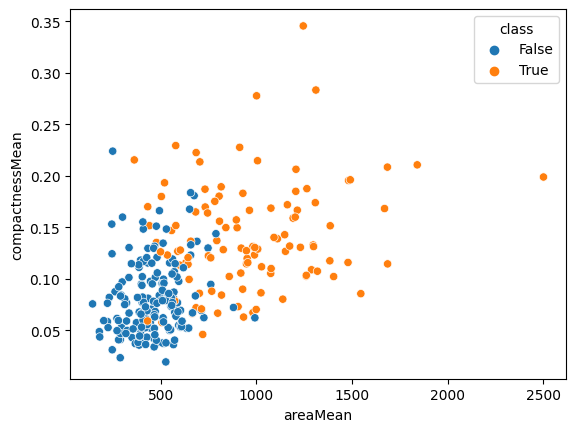

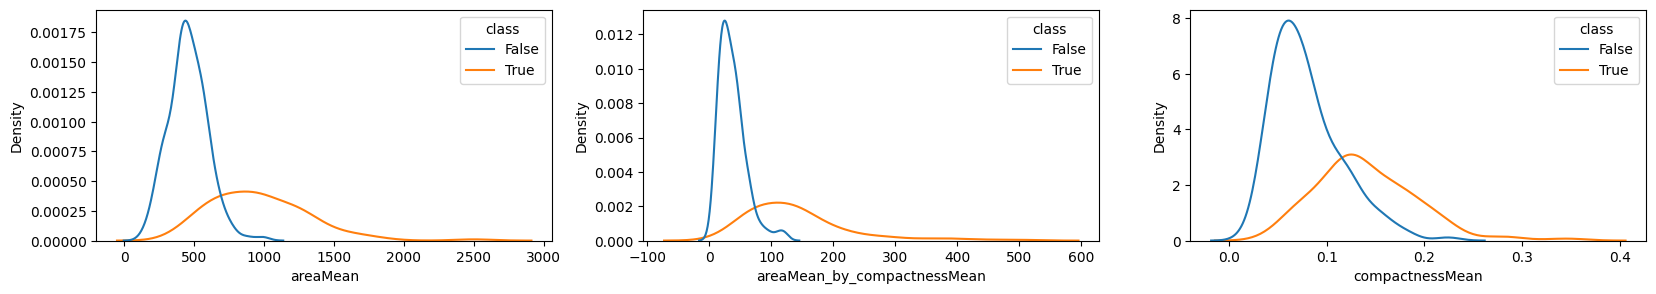

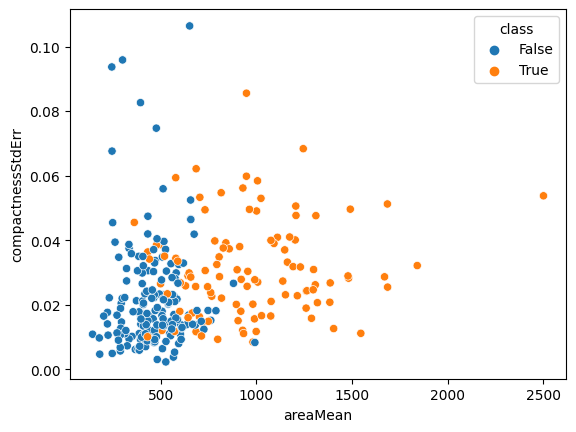

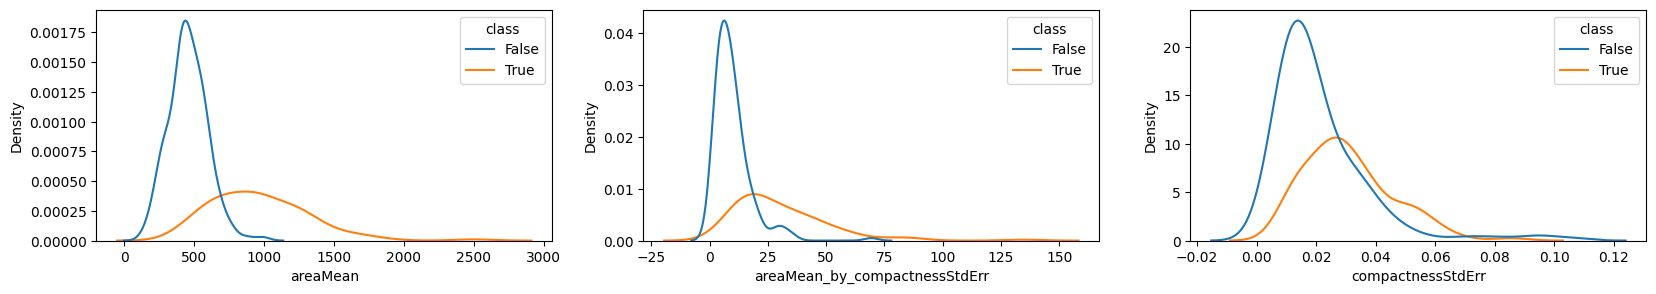

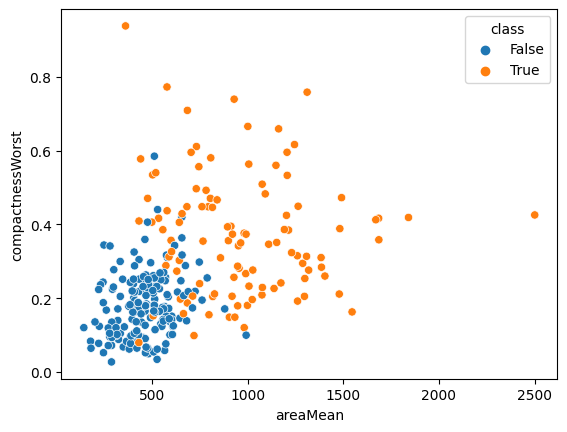

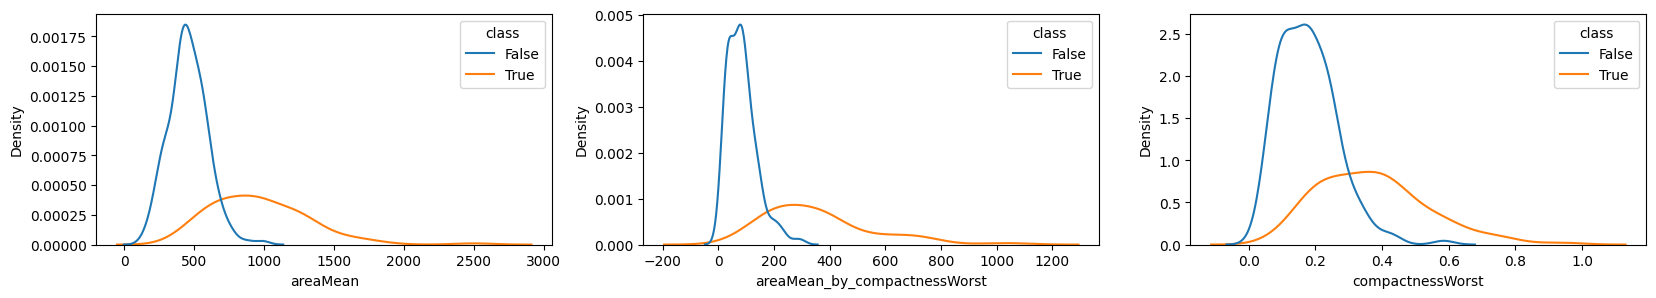

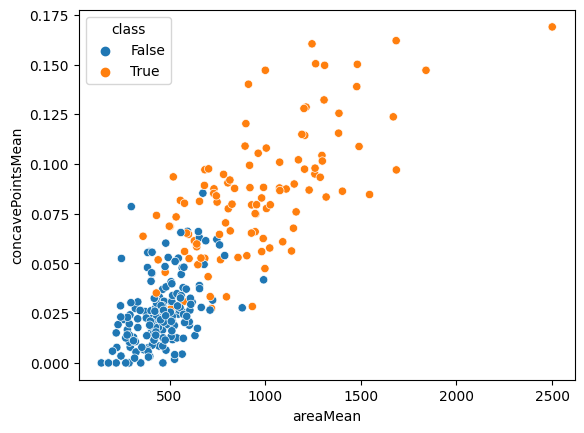

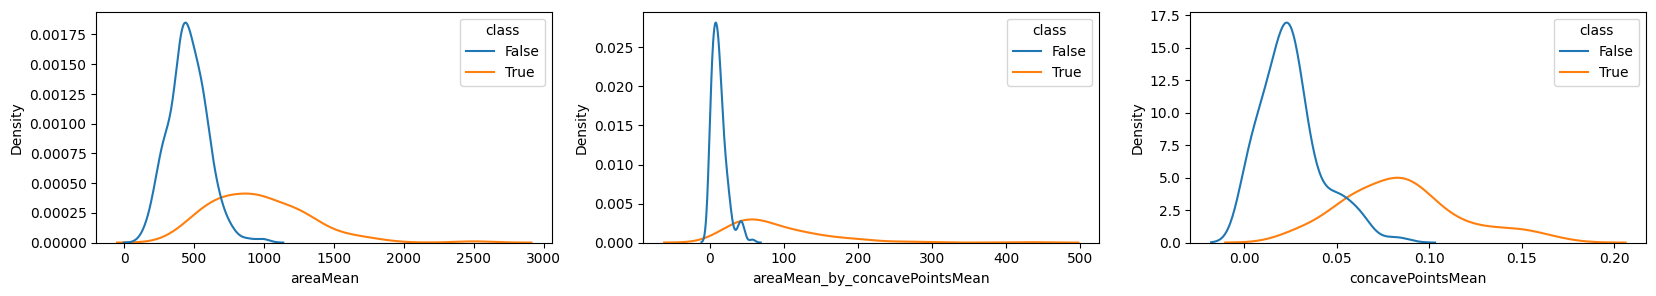

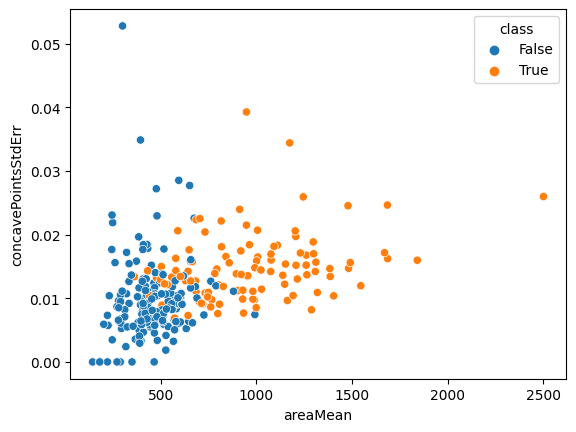

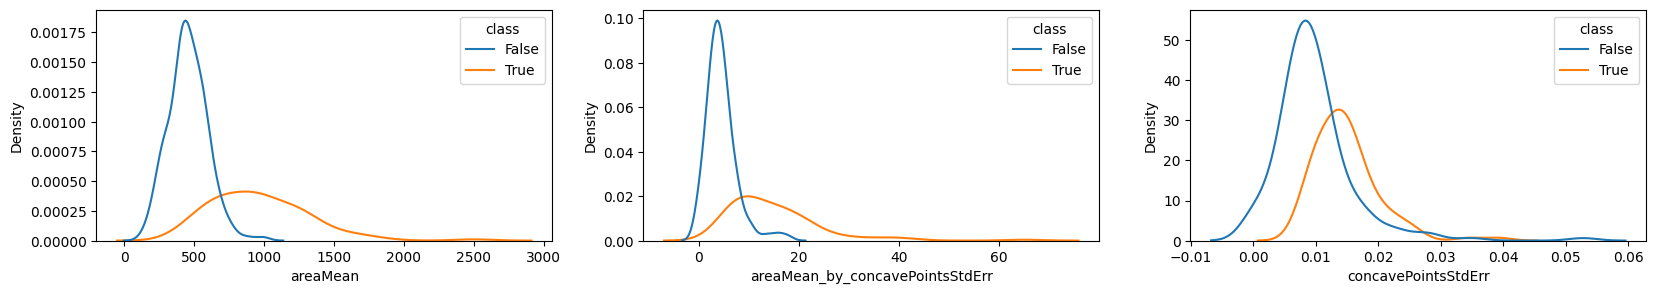

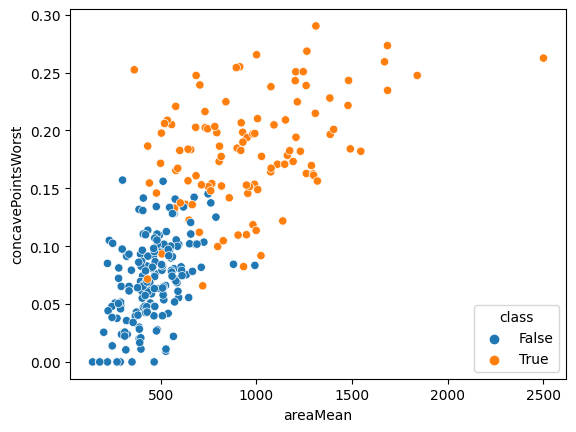

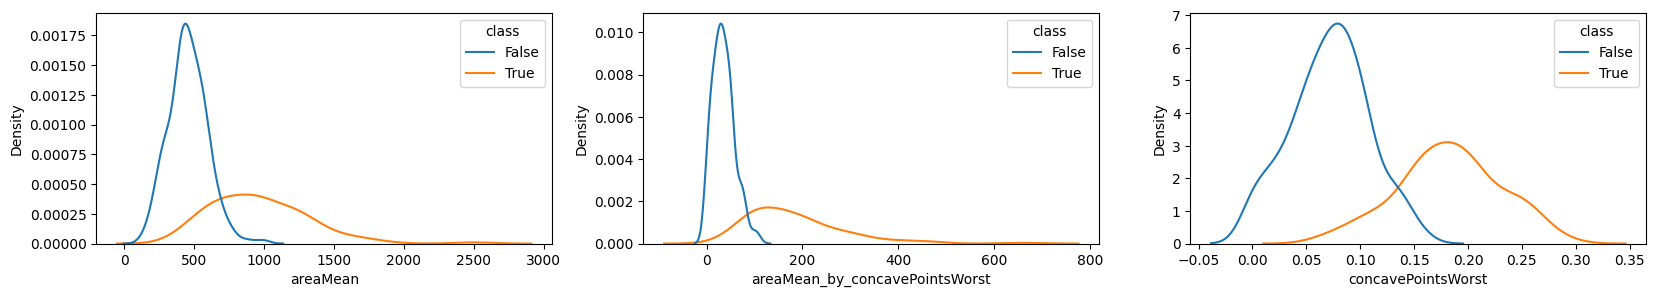

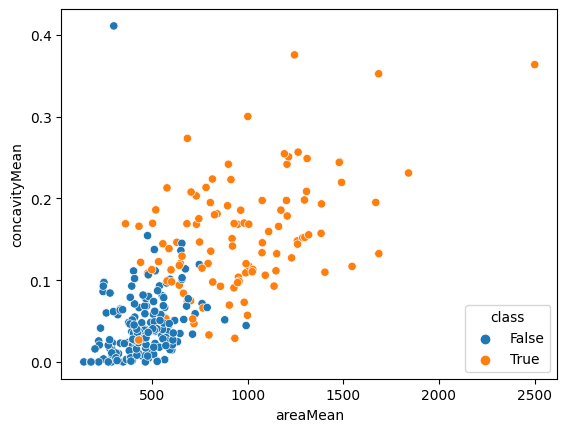

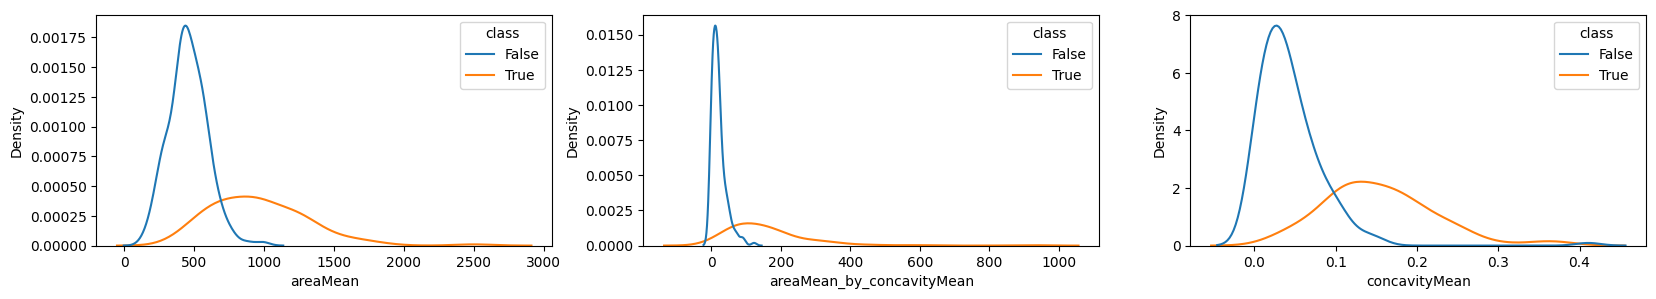

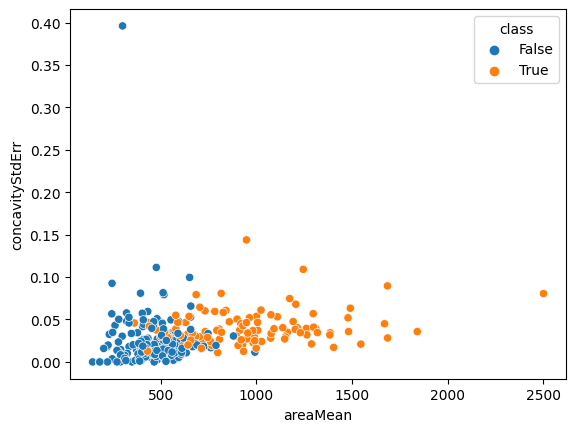

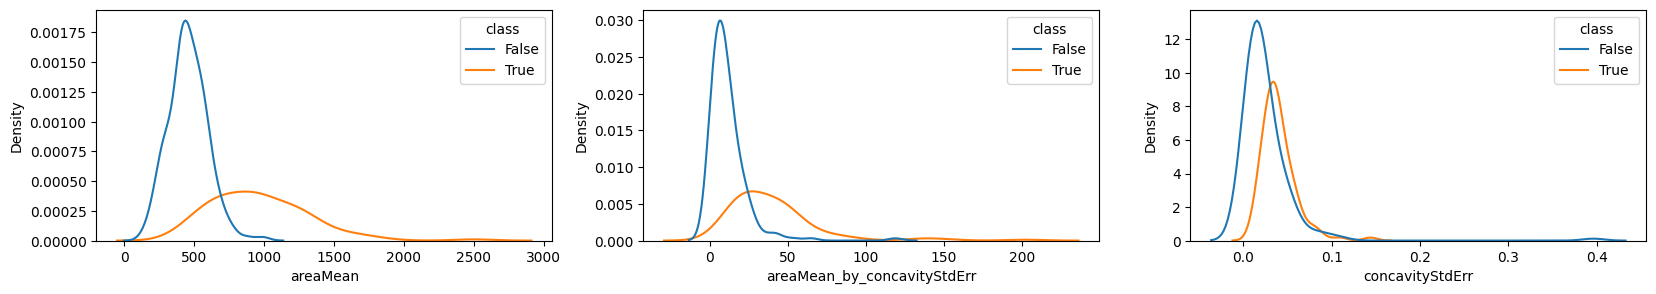

In [89]:
new_feat_df_train = pd.DataFrame({t[2]: t[3] for t in new_cols_train})
new_feat_df_train

new_feat_df_test = pd.DataFrame({t[2]: t[3] for t in new_cols_test})
new_feat_df_test

df_raw_labeled = pd.concat([df_raw_labeled, new_feat_df_train], axis=1)
df_raw_test = pd.concat([df_raw_test, new_feat_df_test], axis=1)

for new_feat in new_cols_train[0:10]:
    col1 = new_feat[0]
    col2 = new_feat[1]
    out_col = new_feat[2]

    plt.figure()
    sns.scatterplot(data=df_raw_labeled, x=col1, y=col2, hue="class")
    
    fig, ax = plt.subplots(1,3, figsize=(20, 3))
    sns.kdeplot(data=df_raw_labeled, x=col1, hue="class", ax=ax[0])
    sns.kdeplot(data=df_raw_labeled, x=out_col, hue="class", ax=ax[1])
    sns.kdeplot(data=df_raw_labeled, x=col2, hue="class", ax=ax[2])

In [90]:
# plt.figure()

# col1 = "radiusStdErr"
# col2 = "concavePointsMean"
# out_col = "radius_by_concave_mean"

# sns.scatterplot(data=df_raw_labeled, x=col1, y=col2, hue="class")

# df_raw_labeled[out_col] = df_raw_labeled[col1] * (df_raw_labeled[col2]+0.0001)
# df_raw_test[out_col] = df_raw_test[col1] * (df_raw_test[col2]+0.0001)

# fig, ax = plt.subplots(1,3, figsize=(20, 5))
# sns.kdeplot(data=df_raw_labeled, x=col1, hue="class", ax=ax[0])
# sns.kdeplot(data=df_raw_labeled, x=out_col, hue="class", ax=ax[1])
# sns.kdeplot(data=df_raw_labeled, x=col2, hue="class", ax=ax[2])

<Axes: xlabel='areaMean', ylabel='Density'>

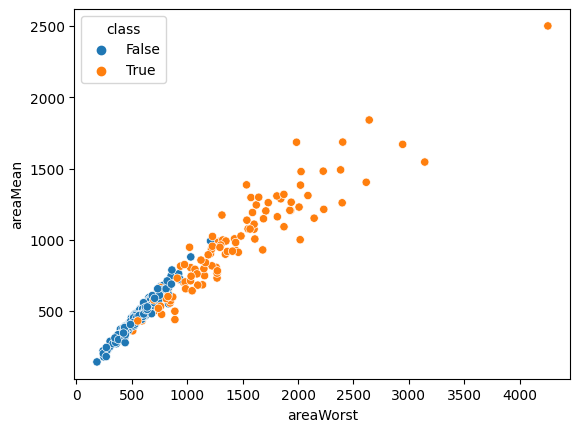

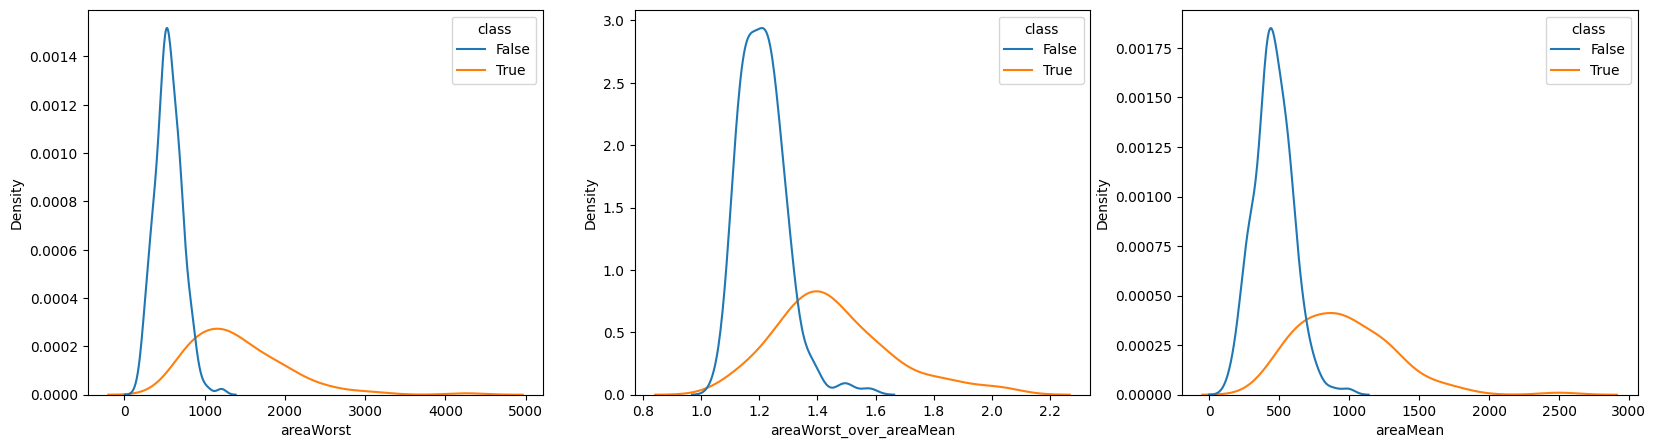

In [91]:
plt.figure()

col1 = "areaWorst"
col2 = "areaMean"
out_col = f"{col1}_over_{col2}"

sns.scatterplot(data=df_raw_labeled, x=col1, y=col2, hue="class")

df_raw_labeled[out_col] = df_raw_labeled[col1] / (df_raw_labeled[col2]+0.0001)
df_raw_test[out_col] = df_raw_test[col1] / (df_raw_test[col2]+0.0001)

fig, ax = plt.subplots(1,3, figsize=(20, 5))
sns.kdeplot(data=df_raw_labeled, x=col1, hue="class", ax=ax[0])
sns.kdeplot(data=df_raw_labeled, x=out_col, hue="class", ax=ax[1])
sns.kdeplot(data=df_raw_labeled, x=col2, hue="class", ax=ax[2])

<Axes: xlabel='radiusMean', ylabel='Density'>

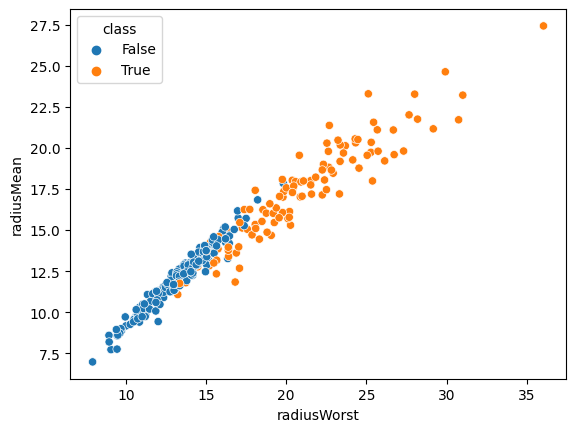

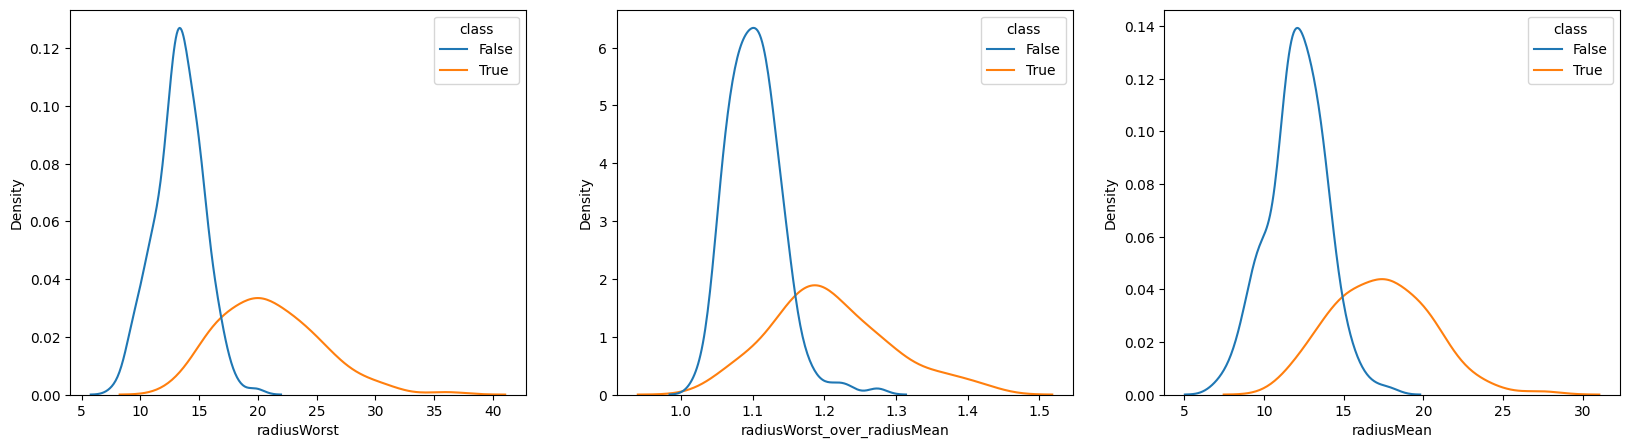

In [92]:
plt.figure()

col1 = "radiusWorst"
col2 = "radiusMean"
out_col = f"{col1}_over_{col2}"

sns.scatterplot(data=df_raw_labeled, x=col1, y=col2, hue="class")

df_raw_labeled[out_col] = df_raw_labeled[col1] / (df_raw_labeled[col2]+0.0001)
df_raw_test[out_col] = df_raw_test[col1] / (df_raw_test[col2]+0.0001)

fig, ax = plt.subplots(1,3, figsize=(20, 5))
sns.kdeplot(data=df_raw_labeled, x=col1, hue="class", ax=ax[0])
sns.kdeplot(data=df_raw_labeled, x=out_col, hue="class", ax=ax[1])
sns.kdeplot(data=df_raw_labeled, x=col2, hue="class", ax=ax[2])

In [93]:
plt.figure()

col1 = "perimeterMean"
col2 = "radiusMean"
out_col = f"{col1}_over_{col2}"

sns.scatterplot(data=df_raw_labeled, x=col1, y=col2, hue="class")

df_raw_labeled[out_col] = df_raw_labeled[col1] / (df_raw_labeled[col2]+0.0001)
df_raw_test[out_col] = df_raw_test[col1] / (df_raw_test[col2]+0.0001)

fig, ax = plt.subplots(1,3, figsize=(20, 5))
sns.kdeplot(data=df_raw_labeled, x=col1, hue="class", ax=ax[0])
sns.kdeplot(data=df_raw_labeled, x=out_col, hue="class", ax=ax[1])
sns.kdeplot(data=df_raw_labeled, x=col2, hue="class", ax=ax[2])

<Axes: xlabel='radiusMean', ylabel='Density'>

<Axes: xlabel='radiusWorst', ylabel='Density'>

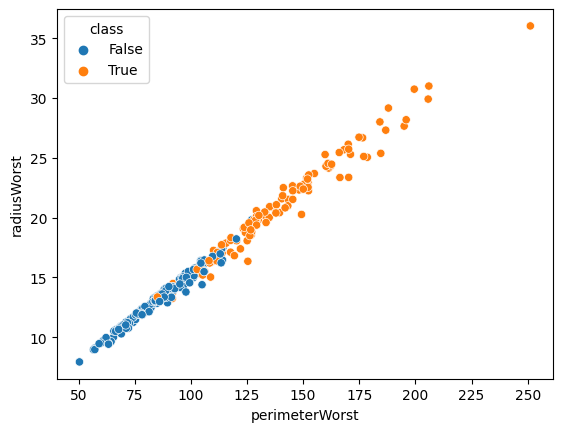

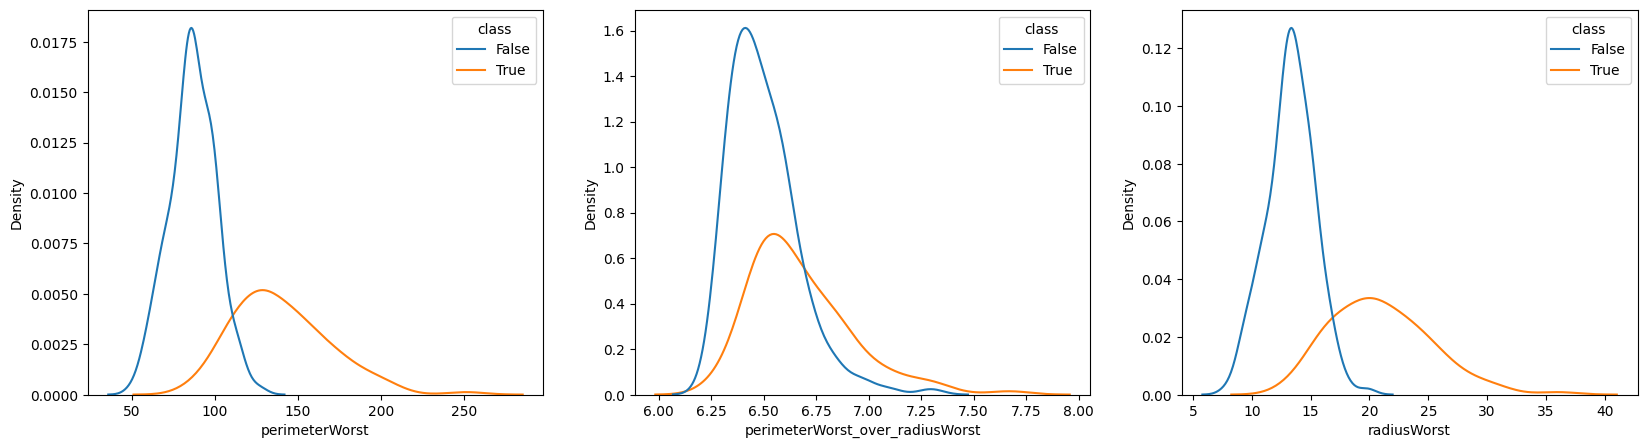

In [94]:
plt.figure()

col1 = "perimeterWorst"
col2 = "radiusWorst"
out_col = f"{col1}_over_{col2}"

sns.scatterplot(data=df_raw_labeled, x=col1, y=col2, hue="class")

df_raw_labeled[out_col] = df_raw_labeled[col1] / (df_raw_labeled[col2]+0.0001)
df_raw_test[out_col] = df_raw_test[col1] / (df_raw_test[col2]+0.0001)

fig, ax = plt.subplots(1,3, figsize=(20, 5))
sns.kdeplot(data=df_raw_labeled, x=col1, hue="class", ax=ax[0])
sns.kdeplot(data=df_raw_labeled, x=out_col, hue="class", ax=ax[1])
sns.kdeplot(data=df_raw_labeled, x=col2, hue="class", ax=ax[2])

<Axes: xlabel='areaMean', ylabel='Density'>

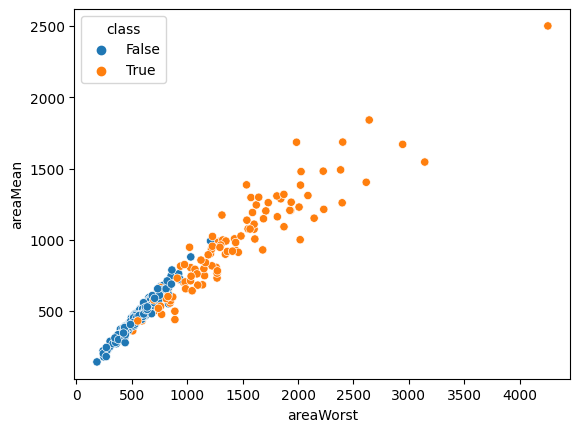

In [95]:
plt.figure()

col1 = "areaWorst"
col2 = "areaMean"
out_col = f"{col1}_diff_{col2}_over_{col2}"

sns.scatterplot(data=df_raw_labeled, x=col1, y=col2, hue="class")

df_raw_labeled[out_col] = (df_raw_labeled[col1] - df_raw_labeled[col2]) / (df_raw_labeled[col2]+0.0001)
df_raw_test[out_col] = (df_raw_test[col1] - df_raw_test[col2]) / (df_raw_test[col2]+0.0001)

fig, ax = plt.subplots(1,3, figsize=(20, 5))
sns.kdeplot(data=df_raw_labeled, x=col1, hue="class", ax=ax[0])
sns.kdeplot(data=df_raw_labeled, x=out_col, hue="class", ax=ax[1])
sns.kdeplot(data=df_raw_labeled, x=col2, hue="class", ax=ax[2])

In [96]:
plt.figure()

col1 = "areaWorst"
col2 = "areaWorst"
out_col = f"{col1}_by_{col2}"

sns.scatterplot(data=df_raw_labeled, x=col1, y=col2, hue="class")

df_raw_labeled[out_col] = df_raw_labeled[col1] * df_raw_labeled[col2]
df_raw_test[out_col] = df_raw_test[col1] * df_raw_test[col2]

fig, ax = plt.subplots(1,3, figsize=(20, 5))
sns.kdeplot(data=df_raw_labeled, x=col1, hue="class", ax=ax[0])
sns.kdeplot(data=df_raw_labeled, x=out_col, hue="class", ax=ax[1])
sns.kdeplot(data=df_raw_labeled, x=col2, hue="class", ax=ax[2])

<Axes: xlabel='areaWorst', ylabel='Density'>

<Axes: xlabel='areaMean', ylabel='Density'>

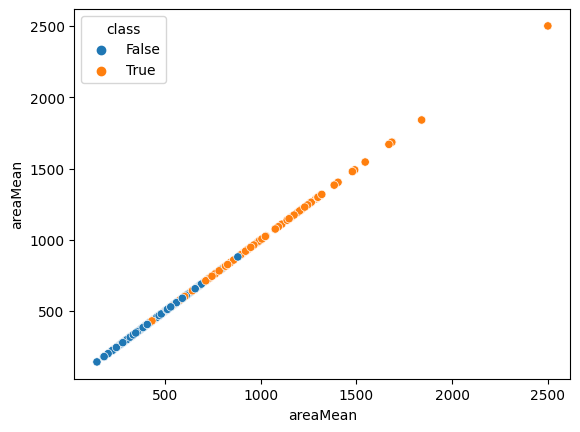

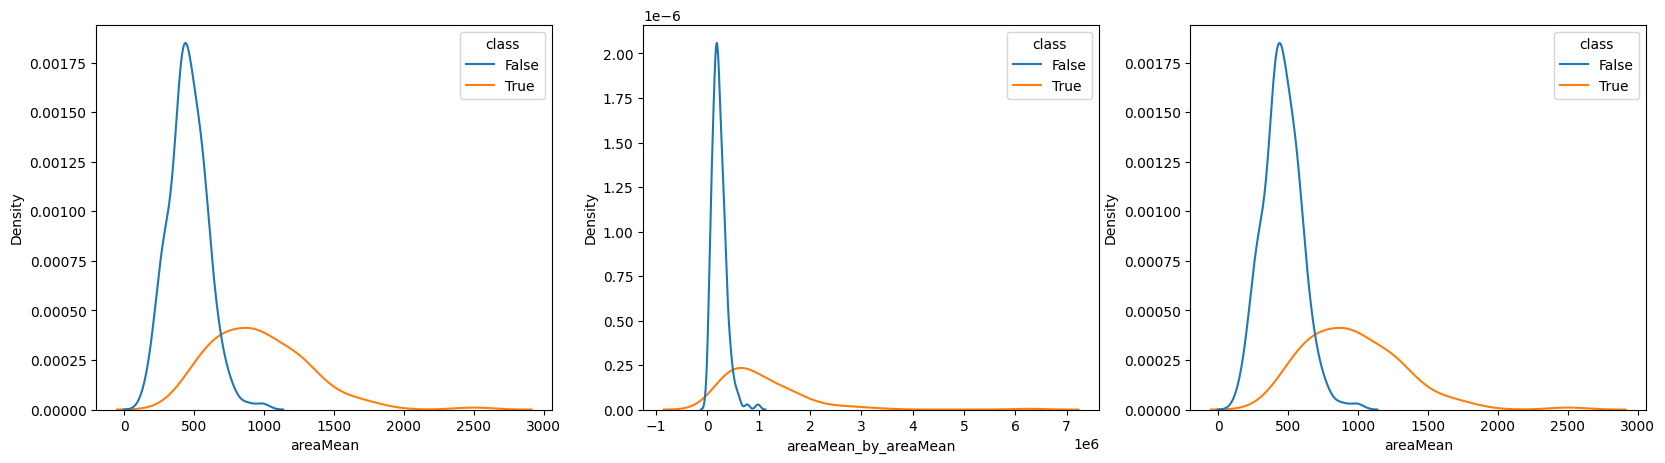

In [97]:
plt.figure()

col1 = "areaMean"
col2 = "areaMean"
out_col = f"{col1}_by_{col2}"

sns.scatterplot(data=df_raw_labeled, x=col1, y=col2, hue="class")

df_raw_labeled[out_col] = df_raw_labeled[col1] * df_raw_labeled[col2]
df_raw_test[out_col] = df_raw_test[col1] * df_raw_test[col2]

fig, ax = plt.subplots(1,3, figsize=(20, 5))
sns.kdeplot(data=df_raw_labeled, x=col1, hue="class", ax=ax[0])
sns.kdeplot(data=df_raw_labeled, x=out_col, hue="class", ax=ax[1])
sns.kdeplot(data=df_raw_labeled, x=col2, hue="class", ax=ax[2])

In [98]:
(df_raw_labeled == np.inf).sum()

ID                                       0
class                                    0
radiusMean                               0
textureMean                              0
perimeterMean                            0
                                        ..
perimeterMean_over_radiusMean            0
perimeterWorst_over_radiusWorst          0
areaWorst_diff_areaMean_over_areaMean    0
areaWorst_by_areaWorst                   0
areaMean_by_areaMean                     0
Length: 474, dtype: int64

## Modeling

In [99]:
step = "FeatureEngineering"

In [100]:
cv_seeds=[0, 1, 7, 42, 100, 120, 123, 666, 999, 100000]
train_cv_dfs, test_cv_dfs = prepare_cv_datasets(df=df_raw_labeled, cv_seeds=cv_seeds, lbl_col="class")

Train rows: 199
Test rows: 86
Train rows: 199
Test rows: 86
Train rows: 199
Test rows: 86
Train rows: 199
Test rows: 86
Train rows: 199
Test rows: 86
Train rows: 199
Test rows: 86
Train rows: 199
Test rows: 86
Train rows: 199
Test rows: 86
Train rows: 199
Test rows: 86
Train rows: 199
Test rows: 86


### LogisticRegression

In [101]:
train_prfs_arr = np.empty((len(cv_seeds), 4))
test_prfs_arr = np.empty((len(cv_seeds), 4))

proportion_lbls_test = np.empty((len(cv_seeds)))

for idx, fold in enumerate(zip(train_cv_dfs, test_cv_dfs)):
    X_train, y_train = fold[0]
    X_test, y_test = fold[1]

    proportion_lbls_test[idx] = y_test.sum() / y_test.count() 
    
    logistic_reg = LogisticRegression(random_state=42)
    logistic_reg.fit(X_train, y_train)
    
    train_y_pred = logistic_reg.predict(X_train)
    test_y_pred = logistic_reg.predict(X_test)
    
    #display_train_test_confusion_matrix(y_train=y_train, y_test=y_test, train_y_pred=train_y_pred, test_y_pred=test_y_pred)
    
    train_prfs = precision_recall_fscore_support(y_train, train_y_pred, average='macro')
    test_prfs = precision_recall_fscore_support(y_test, test_y_pred, average='macro')

    train_prfs_arr[idx] = train_prfs
    test_prfs_arr[idx] = test_prfs

plt.plot(test_prfs_arr[:, 0], label="Precision")
plt.plot(test_prfs_arr[:, 1], label="Recall")
plt.plot(test_prfs_arr[:, 2], label="F1")
plt.xticks(range(test_prfs_arr.shape[0]))
plt.ylabel("Metric")
plt.xlabel("Fold")
plt.ylim(0.0, 1.0)
plt.plot(proportion_lbls_test, label="Real recurrence baseline", linestyle="--")
plt.legend()

train_cv_prfs = train_prfs_arr.mean(axis=0)
test_cv_prfs = test_prfs_arr.mean(axis=0)

print_prfs(prfs=train_cv_prfs, label="Training")
print_prfs(prfs=test_cv_prfs, label="Test")

plt.figure()
sns.boxplot(test_prfs_arr)
ticks = plt.xticks()[0]
plt.xticks(ticks=ticks, labels=["Precision", "Recall", "F1", "Support"])
#plt.ylim(0.0, 1.0)

METRICS["LogisticRegression"][step] = {}
METRICS["LogisticRegression"][step]["train"] = tuple(train_cv_prfs)
METRICS["LogisticRegression"][step]["test"] = tuple(test_cv_prfs)

Training Precision  Training Recall  Training F1
0            0.999184          0.99871     0.998941

Test Precision  Test Recall   Test F1
0        0.958791     0.962688  0.960191

## XGboost

Training Precision  Training Recall  Training F1
0                 1.0              1.0          1.0

Test Precision  Test Recall   Test F1
0        0.952861     0.955953  0.953639

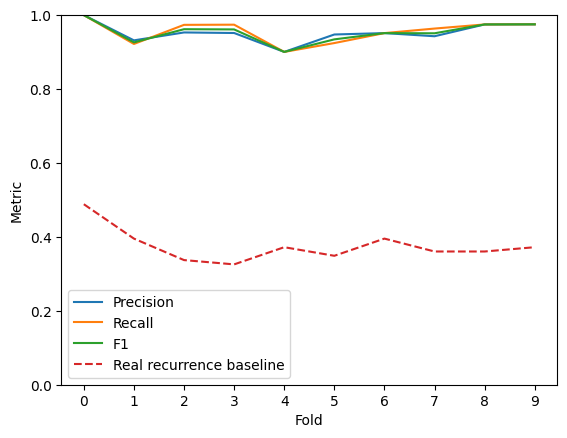

In [102]:
train_prfs_arr = np.empty((len(cv_seeds), 4))
test_prfs_arr = np.empty((len(cv_seeds), 4))

proportion_lbls_test = np.empty((len(cv_seeds)))

for idx, fold in enumerate(zip(train_cv_dfs, test_cv_dfs)):
    X_train, y_train = fold[0]
    X_test, y_test = fold[1]

    proportion_lbls_test[idx] = y_test.sum() / y_test.count() 
    
    xgbc_baseline = XGBClassifier(random_state=42)
    xgbc_baseline.fit(X_train, y_train)
    
    train_y_pred = xgbc_baseline.predict(X_train)
    test_y_pred = xgbc_baseline.predict(X_test)
    
    #display_train_test_confusion_matrix(y_train=y_train, y_test=y_test, train_y_pred=train_y_pred, test_y_pred=test_y_pred)
    
    train_prfs = precision_recall_fscore_support(y_train, train_y_pred, average='macro')
    test_prfs = precision_recall_fscore_support(y_test, test_y_pred, average='macro')

    train_prfs_arr[idx] = train_prfs
    test_prfs_arr[idx] = test_prfs

plt.plot(test_prfs_arr[:, 0], label="Precision")
plt.plot(test_prfs_arr[:, 1], label="Recall")
plt.plot(test_prfs_arr[:, 2], label="F1")
plt.xticks(range(test_prfs_arr.shape[0]))
plt.ylabel("Metric")
plt.xlabel("Fold")
plt.ylim(0.0, 1.0)
plt.plot(proportion_lbls_test, label="Real recurrence baseline", linestyle="--")
plt.legend()

train_cv_prfs = train_prfs_arr.mean(axis=0)
test_cv_prfs = test_prfs_arr.mean(axis=0)

print_prfs(prfs=train_cv_prfs, label="Training")
print_prfs(prfs=test_cv_prfs, label="Test")

plt.figure()
sns.boxplot(test_prfs_arr)
ticks = plt.xticks()[0]
plt.xticks(ticks=ticks, labels=["Precision", "Recall", "F1", "Support"])
#plt.ylim(0.0, 1.0)

METRICS["XGBClassifier"][step] = {}
METRICS["XGBClassifier"][step]["train"] = tuple(train_cv_prfs)
METRICS["XGBClassifier"][step]["test"] = tuple(test_cv_prfs)

### SVM

Training Precision  Training Recall  Training F1
0            0.986804         0.979268     0.982785

Test Precision  Test Recall   Test F1
0        0.971936     0.970733  0.971101

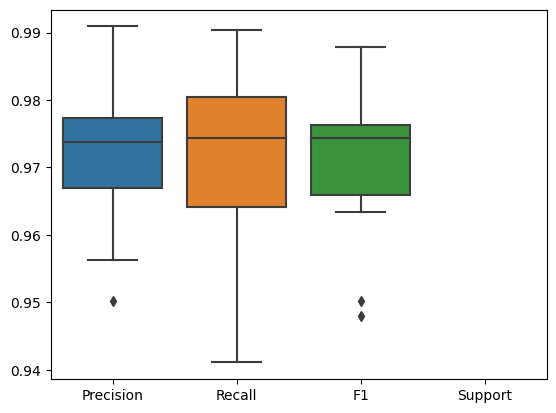

In [103]:
train_prfs_arr = np.empty((len(cv_seeds), 4))
test_prfs_arr = np.empty((len(cv_seeds), 4))

proportion_lbls_test = np.empty((len(cv_seeds)))

for idx, fold in enumerate(zip(train_cv_dfs, test_cv_dfs)):
    X_train, y_train = fold[0]
    X_test, y_test = fold[1]

    proportion_lbls_test[idx] = y_test.sum() / y_test.count() 
    
    clf = svm.SVC(random_state=42)
    clf.fit(X_train, y_train)
    
    train_y_pred = clf.predict(X_train)
    test_y_pred = clf.predict(X_test)
    
    #display_train_test_confusion_matrix(y_train=y_train, y_test=y_test, train_y_pred=train_y_pred, test_y_pred=test_y_pred)
    
    train_prfs = precision_recall_fscore_support(y_train, train_y_pred, average='macro')
    test_prfs = precision_recall_fscore_support(y_test, test_y_pred, average='macro')

    train_prfs_arr[idx] = train_prfs
    test_prfs_arr[idx] = test_prfs
plt.plot(test_prfs_arr[:, 0], label="Precision")
plt.plot(test_prfs_arr[:, 1], label="Recall")
plt.plot(test_prfs_arr[:, 2], label="F1")
plt.xticks(range(test_prfs_arr.shape[0]))
plt.ylabel("Metric")
plt.xlabel("Fold")
plt.ylim(0.0, 1.0)
plt.plot(proportion_lbls_test, label="Real recurrence baseline", linestyle="--")
plt.legend()

train_cv_prfs = train_prfs_arr.mean(axis=0)
test_cv_prfs = test_prfs_arr.mean(axis=0)

print_prfs(prfs=train_cv_prfs, label="Training")
print_prfs(prfs=test_cv_prfs, label="Test")

plt.figure()
sns.boxplot(test_prfs_arr)
ticks = plt.xticks()[0]
plt.xticks(ticks=ticks, labels=["Precision", "Recall", "F1", "Support"])
#plt.ylim(0.0, 1.0)

METRICS["SVM"][step] = {}
METRICS["SVM"][step]["train"] = tuple(train_cv_prfs)
METRICS["SVM"][step]["test"] = tuple(test_cv_prfs)

## Metrics so far

(0.9587907454030118, 0.9626875643272031, 0.9601912246218021, nan)
(0.9528607413860728, 0.9559525196877467, 0.9536388319237472, nan)
(0.9719362962868372, 0.970733295112872, 0.9711005104263233, nan)


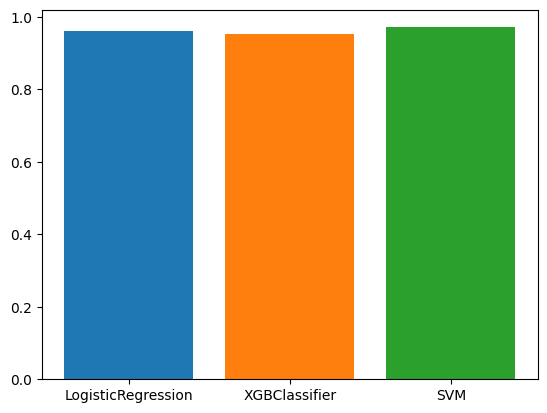

In [104]:
for k,v in METRICS.items():
    print(v[step]["test"])

    plt.bar(x=k, height=v[step]["test"][2])

In [105]:
print(json.dumps(METRICS, indent=4))

{
    "LogisticRegression": {
        "Baseline": {
            "train": [
                0.9928094003905628,
                0.9880805355747061,
                0.9903358587689869,
                NaN
            ],
            "test": [
                0.9590103646062971,
                0.9592824297104077,
                0.9587062005225739,
                NaN
            ]
        },
        "FeatureEngineering": {
            "train": [
                0.9991836598693856,
                0.9987096237096237,
                0.9989407790196922,
                NaN
            ],
            "test": [
                0.9587907454030118,
                0.9626875643272031,
                0.9601912246218021,
                NaN
            ]
        }
    },
    "XGBClassifier": {
        "Baseline": {
            "train": [
                1.0,
                1.0,
                1.0,
                NaN
            ],
            "test": [
                0.9357942913750528,
    

## Final Feature Engineering Model

In [106]:
X_train, y_train = get_X_y(df_raw_labeled, lbl_col="class")
X_test = df_raw_test.drop("ID", axis=1)

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

xgbc = XGBClassifier(random_state=42)
xgbc.fit(X_train, y_train)

train_y_pred = xgbc.predict(X_train)
test_y_pred = xgbc.predict(X_test)

train_prfs = precision_recall_fscore_support(y_train, train_y_pred, average='macro')
train_prfs

(1.0, 1.0, 1.0, None)

In [107]:
submission_dt = dt.datetime.now().strftime("%Y%m%d_%H%M%S")

submission = pd.DataFrame({"ID": df_raw_test["ID"], "class": test_y_pred})
submission = submission.replace({0: "false", 1: "true"})
submission 

save_path = "submissions/feat_engineering/xgb"
sub = "."
for part in save_path.split("/"):
    sub = sub + "/" + part 
    try:
        os.mkdir(sub)
        print(f"Created path {sub}")
    except FileExistsError:
        print(f"Path {sub} already exists.")
        pass

submission.to_csv(f"{save_path}/submission_logreg_{submission_dt}.csv", index=False)

Path ./submissions already exists.
Path ./submissions/feat_engineering already exists.
Path ./submissions/feat_engineering/xgb already exists.


In [108]:
submission.groupby("class").count()

ID
class     
false  184
true   100

In [109]:
X_train, y_train = get_X_y(df_raw_labeled, lbl_col="class")
X_test = df_raw_test.drop("ID", axis=1)

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)

train_y_pred = log_reg.predict(X_train)
test_y_pred = log_reg.predict(X_test)

train_prfs = precision_recall_fscore_support(y_train, train_y_pred, average='macro')
train_prfs

(0.994413407821229, 0.9907407407407407, 0.9925181140396935, None)

In [110]:
submission_dt = dt.datetime.now().strftime("%Y%m%d_%H%M%S")

submission = pd.DataFrame({"ID": df_raw_test["ID"], "class": test_y_pred})
submission = submission.replace({False: "false", True: "true"})
submission 

save_path = "submissions/feat_engineering/log_reg"
sub = "."
for part in save_path.split("/"):
    sub = sub + "/" + part 
    try:
        os.mkdir(sub)
        print(f"Created path {sub}")
    except FileExistsError:
        print(f"Path {sub} already exists.")
        pass

submission.to_csv(f"{save_path}/submission_xgb_{submission_dt}.csv", index=False)

Path ./submissions already exists.
Path ./submissions/feat_engineering already exists.
Path ./submissions/feat_engineering/log_reg already exists.


In [111]:
submission.groupby("class").count()

ID
class     
false  182
true   102

In [113]:
X_train, y_train = get_X_y(df_raw_labeled, lbl_col="class")
X_test = df_raw_test.drop("ID", axis=1)

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

clf = svm.SVC(random_state=42)
clf.fit(X_train, y_train)

train_y_pred = clf.predict(X_train)
test_y_pred = clf.predict(X_test)

train_prfs = precision_recall_fscore_support(y_train, train_y_pred, average='macro')
train_prfs

(0.9841269841269842, 0.9786566227244193, 0.9812601096776739, None)

In [114]:
test_y_pred

array([False, False, False, False,  True, False, False, False, False,
       False,  True, False,  True, False, False, False, False, False,
        True,  True,  True, False, False,  True,  True, False, False,
       False, False, False, False,  True, False,  True, False,  True,
       False, False,  True, False, False, False, False,  True, False,
       False, False, False,  True, False, False, False, False,  True,
       False, False,  True,  True, False,  True,  True, False, False,
        True, False,  True, False, False, False,  True, False, False,
        True,  True, False, False,  True,  True, False, False, False,
       False, False,  True, False, False, False,  True,  True, False,
       False,  True,  True, False, False, False, False, False, False,
        True,  True,  True, False,  True, False,  True, False, False,
       False, False,  True, False, False,  True, False,  True, False,
       False,  True, False, False, False,  True, False,  True,  True,
       False, False,

In [115]:
submission_dt = dt.datetime.now().strftime("%Y%m%d_%H%M%S")

submission = pd.DataFrame({"ID": df_raw_test["ID"], "class": test_y_pred})
submission = submission.replace({False: "false", True: "true"})
submission 

save_path = "submissions/feat_engineering/svm"
sub = "."
for part in save_path.split("/"):
    sub = sub + "/" + part 
    try:
        os.mkdir(sub)
        print(f"Created path {sub}")
    except FileExistsError:
        print(f"Path {sub} already exists.")
        pass

submission.to_csv(f"{save_path}/submission_svm_{submission_dt}.csv", index=False)

Path ./submissions already exists.
Path ./submissions/feat_engineering already exists.
Created path ./submissions/feat_engineering/svm


In [112]:
# df_logreg_importance = pd.DataFrame({"feature": df_raw_test.drop("ID", axis=1).columns, "coef": logistic_reg.coef_[0]})

# sns.barplot(data=df_logreg_importance, x="feature", y="coef")
# plt.xticks(rotation=90);